<a href="https://colab.research.google.com/github/FedericoVaona99/Wind-Power-Generation-Forecasting-SMDS/blob/main/Progetto_WindEnergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 - Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
import statsmodels.tsa.stattools as st
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Specific importing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
!pip install statsforecast
from statsforecast.models import HistoricAverage
from statsforecast.models import Naive
from statsforecast.models import SeasonalNaive
from statsforecast.models import RandomWalkWithDrift
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsforecast import StatsForecast
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# 1 - **Data Cleaning**

Loading, converting and cleaning of the data

In [ ]:
df = pd.read_csv('WindEnergy.csv', sep=',', parse_dates=['utc_timestamp'], index_col='utc_timestamp')
df = df.asfreq('D')
df.head()

wind_generation_actual  wind_capacity  temperature
utc_timestamp                                                                
2017-01-01 00:00:00+00:00                291760.0      37149.130       -2.117
2017-01-02 00:00:00+00:00                295097.0      37152.125       -1.154
2017-01-03 00:00:00+00:00                666170.0      37155.208       -0.239
2017-01-04 00:00:00+00:00                686581.0      37160.125        0.620
2017-01-05 00:00:00+00:00                261759.0      37163.542       -3.908

This dataset contains daily observations recorded in Germany from 2017 to 2019, including the following variables:

**`Wind generation actual:`** The actual amount of electricity produced by wind turbines (in MWh).

**`Wind capacity:`** The installed wind power capacity available on a given day (in MW).

**`Temperature:`** The average daily air temperature (in °C).

In [ ]:
# Rename columns for simplicity
df.columns = ['wind_generation', 'wind_capacity', 'temperature']

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2017-01-01 00:00:00+00:00 to 2019-12-30 00:00:00+00:00
Freq: D
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   wind_generation  1094 non-null   float64
 1   wind_capacity    1094 non-null   float64
 2   temperature      1094 non-null   float64
dtypes: float64(3)
memory usage: 34.2 KB


In [ ]:
# Check for missing data (NaN values)
missing_values = df.isnull().sum()
missing_values

wind_generation    0
wind_capacity      0
temperature        0
dtype: int64

The check for null (NaN) values confirmed that there are no missing entries, so the data is already clean and ready for analysis.

In [ ]:
df.describe().T.round(2)

count       mean        std       min        25%        50%  \
wind_generation  1094.0  305819.77  205728.86  16482.00  148552.75  254332.50   
wind_capacity    1094.0   45066.02    4315.84  37149.13   41447.94   46073.00   
temperature      1094.0      10.05       7.74     -9.36       3.58      10.05   

                       75%        max  
wind_generation  412570.50  998899.00  
wind_capacity     49203.00   50452.00  
temperature          16.57      28.24

# 2 - **Exploratory Data Analysis**

Exploring the dataset with **descriptive statistics** and **frequency analysis**. Use appropriate graphs to visualise the data at hand

## 2.1 - Descriptive Statistics

### 2.1.1 - LinePlots

We start the analysis by plotting line graphs for each feature to observe their behavior over time.  
Lineplots are useful here to capture trends, seasonality, and fluctuations in the data.

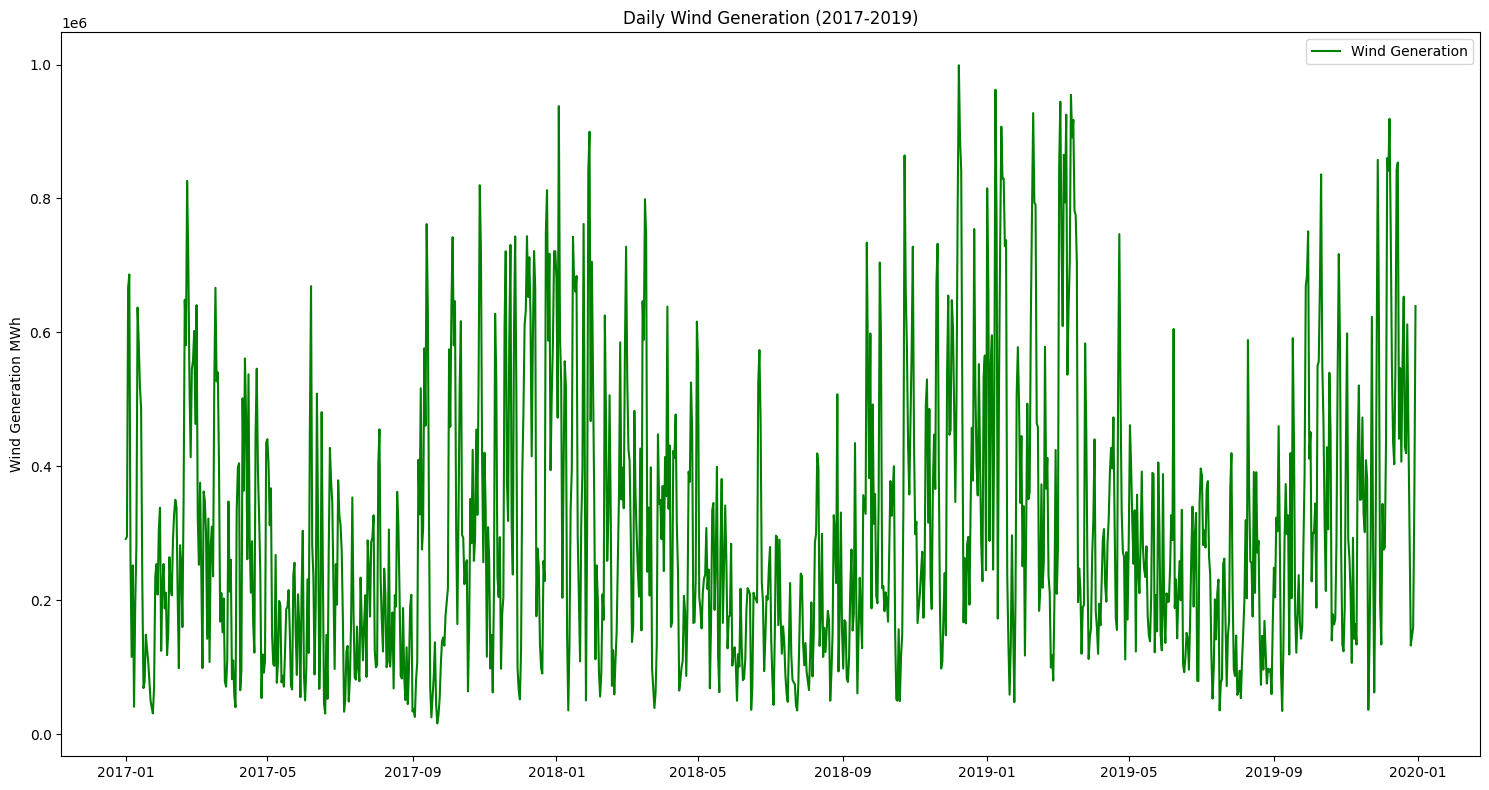

In [ ]:
# Generating plots for the three variables

plt.figure(figsize=(15, 8))

plt.plot(df['wind_generation'], label='Wind Generation', color='green')
plt.title('Daily Wind Generation (2017-2019)')
plt.ylabel('Wind Generation MWh')
plt.legend()

plt.tight_layout()
plt.show()

**Daily Wind Generation:**

This is the target variable that we aim to predict.
The series exhibits strong variability and irregular peaks, suggesting a non-stationary process with seasonal components.



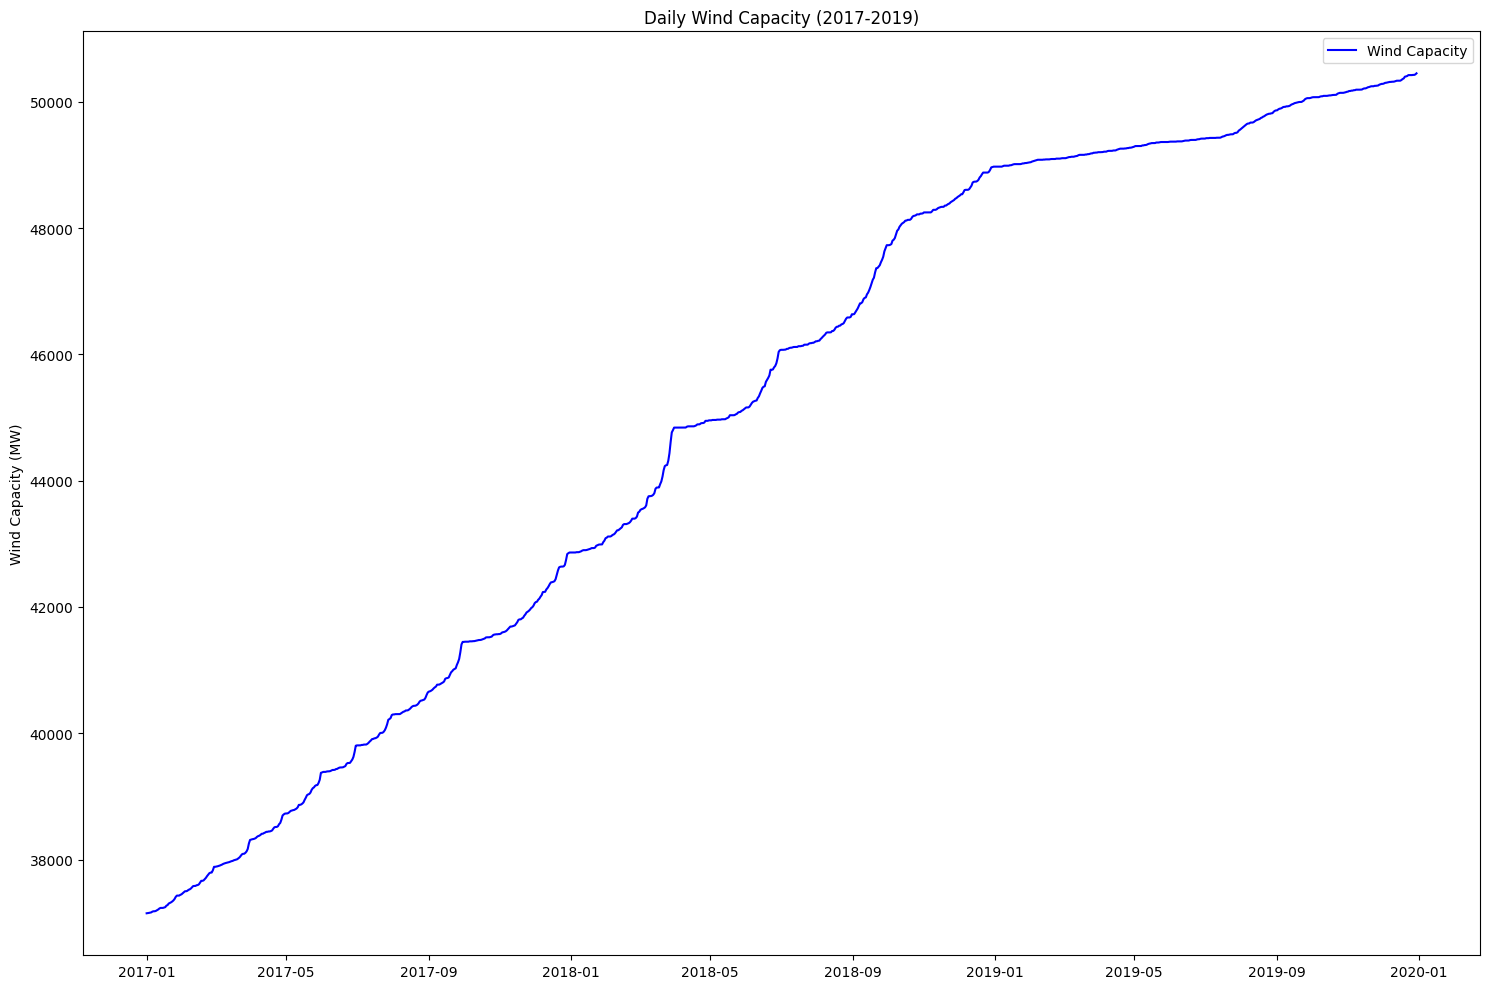

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(df['wind_capacity'], label='Wind Capacity', color='blue')
plt.title('Daily Wind Capacity (2017-2019)')
plt.ylabel('Wind Capacity (MW)')
plt.legend()

plt.tight_layout()
plt.show()

**Daily Wind Capacity:**

The plot shows the cumulative daily wind capacity installed in Germany from 2017 to 2019.
The steady upward trend indicates continuous expansion.


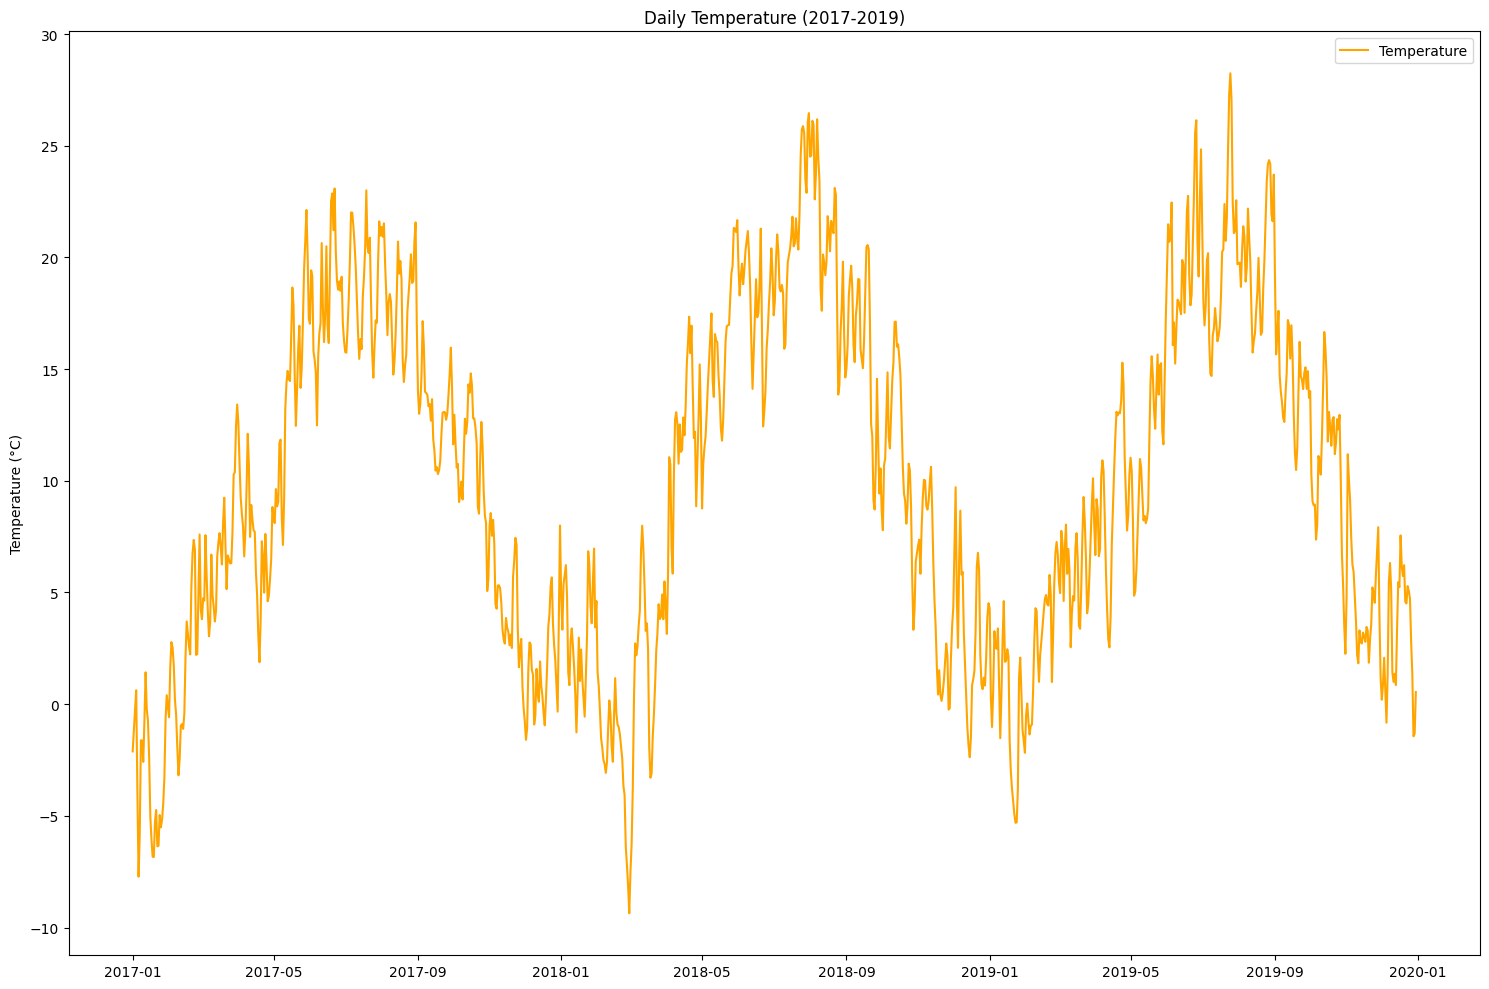

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(df['temperature'], label='Temperature', color='orange')
plt.title('Daily Temperature (2017-2019)')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.tight_layout()
plt.show()

**Daily Temperature:**

*   It displays clear annual seasonality, with winter lows and summer highs.
*   It may be inversely correlated with wind production -> cold periods may be windier.

### 2.1.2 - Histograms and BoxPlots

Next, we proceed with histograms to examine the distribution of each feature.  
Histograms help us understand the spread, central tendency, and presence of outliers or skewness in the data.  
This step complements the time-based line plots by focusing on the overall frequency distribution of values.


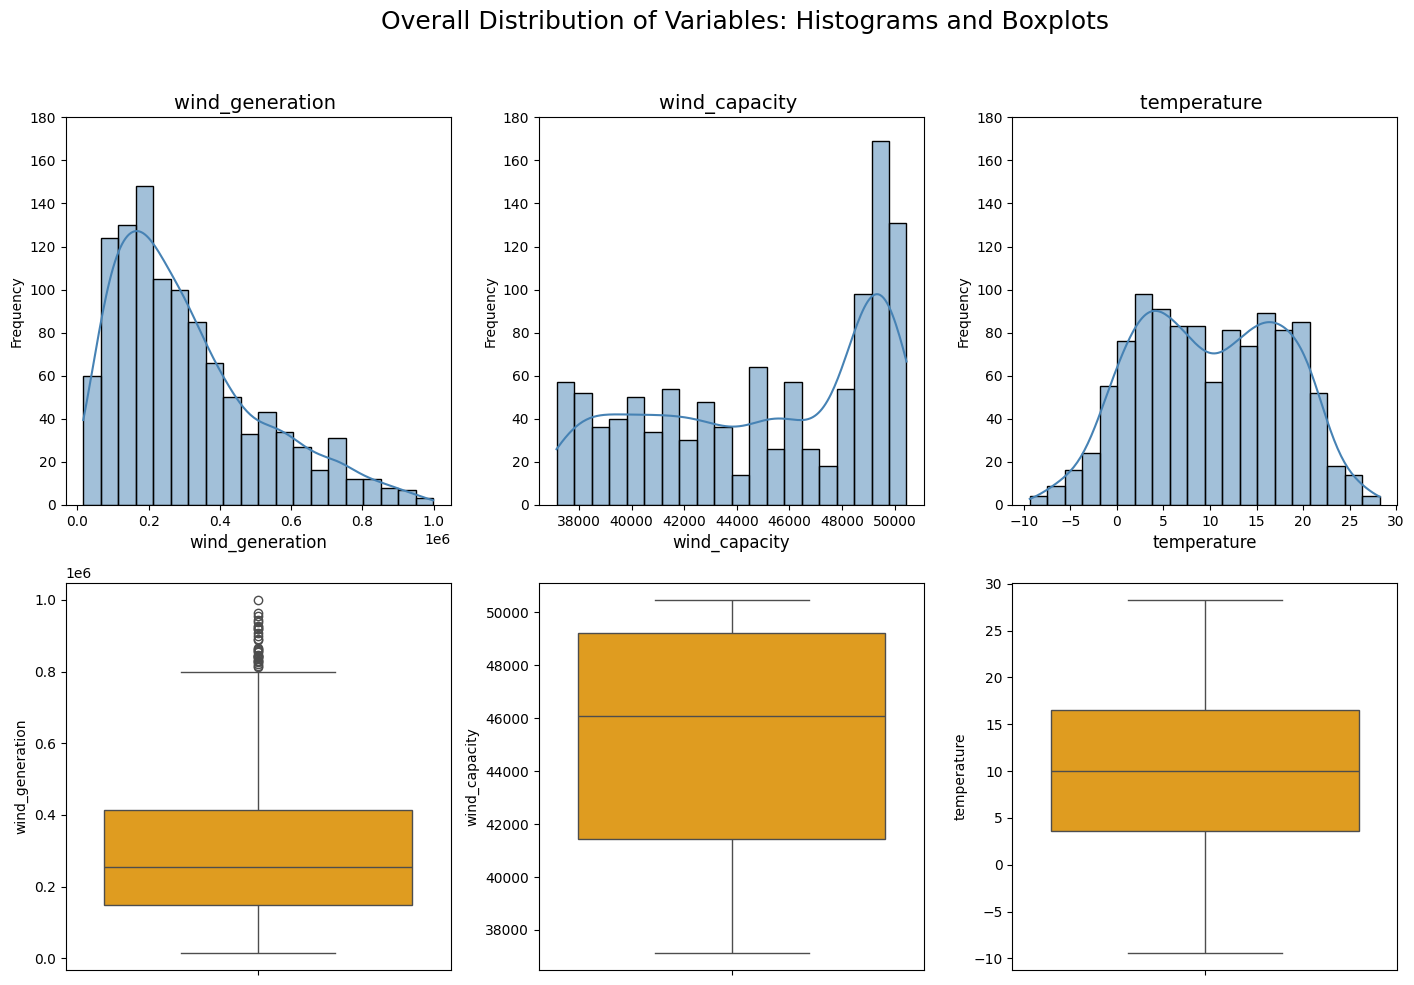

In [ ]:
variables = df.columns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Overall Distribution of Variables: Histograms and Boxplots', fontsize=18)

# First row: Histograms
for ax, var in zip(axes[0], variables):
    sns.histplot(data=df, x=var, bins=20, kde=True, color='steelblue', ax=ax)
    ax.set_title(f'{var} ', fontsize=14)
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Frequency')
    ax.set_ylim(0, 180)

# Second row: boxplots
for ax, var in zip(axes[1], variables):
    sns.boxplot(y=df[var], color='Orange', ax=ax)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


**`wind_generation`** is a **right-skewed distribution** with most values concentrated below 400,000 MWh.

The boxplot confirms this asymmetry, showing a median around 250,000 MWh and several high outliers above 800,000 MWh.


Both wind_capacity and temperature show reasonably well-distributed values with no significant outliers. These features appear stable and suitable as explanatory variables for wind generation modeling.


### 2.1.3 - ViolinPlots

Violin plots combine histograms and boxplots, providing a comprehensive overview of both the distribution and the density of each variable.


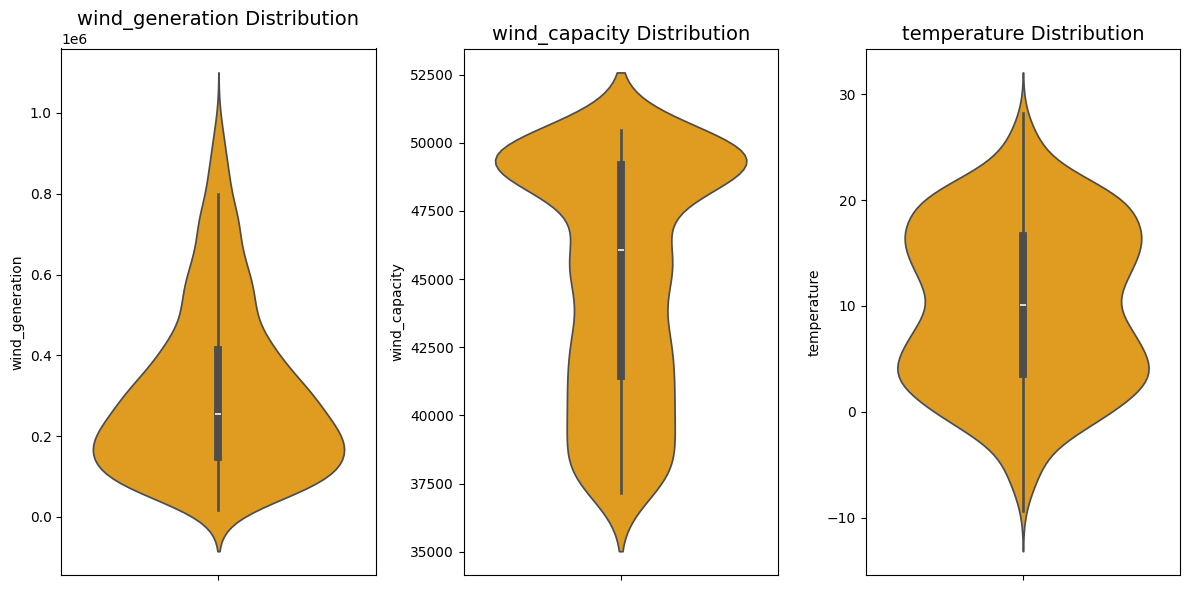

In [ ]:
variables = df.columns

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for ax, var in zip(axes, variables):
    sns.violinplot(y=df[var], color='orange', ax=ax)
    ax.set_title(f'{var} Distribution', fontsize=14)

plt.tight_layout()
plt.show()



Violin plots confirm previous distributions, highlighting the skewness in wind_generation and the multimodality in temperature and wind_capacity.

### 2.1.4 - Outlier


Here, we do a quick analysis on the outlier spotted in section 2.1.2 for the feature **`wind_generation`**

In [ ]:
Q1_py = np.quantile(df.wind_generation,0.25)
Q3_py = np.quantile(df.wind_generation,0.75)
IQR = Q3_py-Q1_py
Lower_Fence = Q1_py - 1.5*IQR
Upper_Fence = Q3_py + 1.5*IQR

T = 0
for i in df.wind_generation:
    exp1 = i < Lower_Fence
    exp2 = i > Upper_Fence
    if exp1 or exp2:
       T += 1

print('The total number of outliers is', T, ', which is', round(T/len(df)*100,2), '% of the dataset')

The total number of outliers is 30 , which is 2.74 % of the dataset


The number of outliers in the `wind_generation` series was identified using the IQR (Interquartile Range) method. Although they represent a small percentage of the dataset, these values may reflect extreme weather conditions that significantly boosted wind production. Their presence is consistent with the inherent variability of renewable energy sources.


### 2.1.5 - Correlation

Finding correlation between features it's important to identify potential linear relationships and decide whether additional predictors (e.g., exogenous variables) might improve forecasting models.

**HEATMAP**

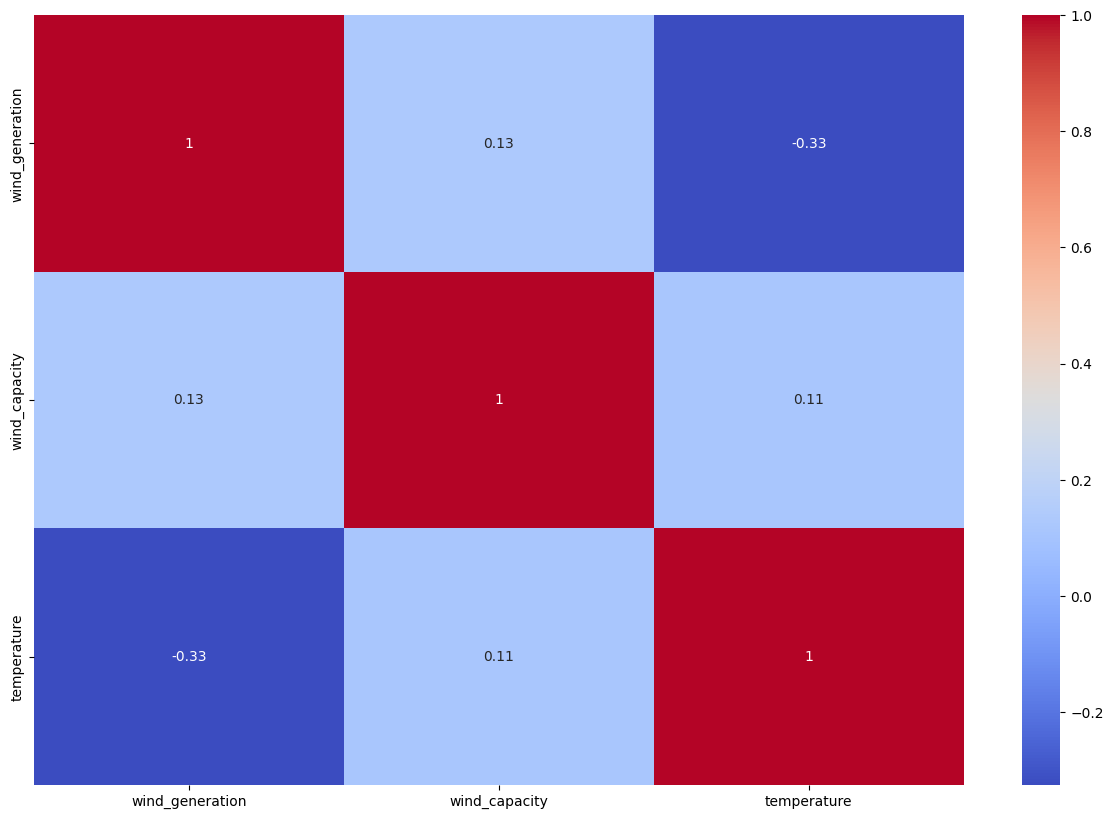

In [ ]:
plt.figure(figsize=(15,10))
corr = df.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.show()

The correlation matrix shows a weak negative correlation between `temperature` and `wind generation` (-0.33), suggesting that colder periods tend to have higher wind production.
Correlations with `wind capacity` are very low. indicating minimal linear association with the other variables.

Based on this, `temperature` may be considered as a potential exogenous regressor in forecasting models like SARIMAX, while wind capacity appears less informative.

**SCATTER PLOT**

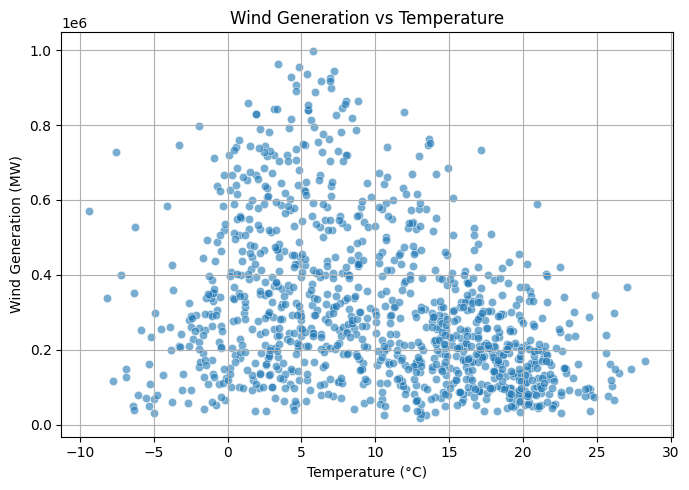

In [ ]:
# Wind Generation vs Temperature scatter plot

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x='temperature', y='wind_generation', alpha=0.6)
plt.title("Wind Generation vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Wind Generation (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()


The scatter plot confirms that the highest wind generation values tend to occur at lower temperatures. While the relationship is not strictly linear, it visually supports the moderate negative correlation observed earlier.

## 2.2 - Frequency Analysis

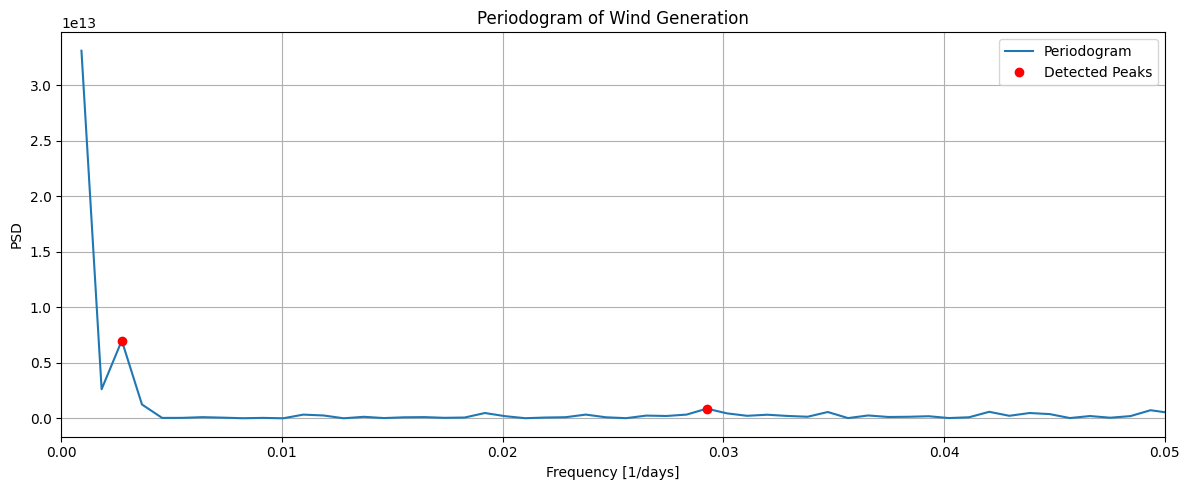

Detected Seasonalities: (Periods > 30 days)



Frequency [1/days]       Density  Period [days]
0            0.002742  7.006189e+12     364.666667
1            0.029250  8.751002e+11      34.187500

In [ ]:
f_per, Pxx_per = signal.periodogram(df['wind_generation'], fs=1, detrend=None, window='hann', return_onesided=True, scaling='density')

# Remove 0 frequency
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

# Peak detection
prominence_threshold = np.percentile(Pxx_per, 99)  # consider peaks in the top 1% of power
peaks = signal.find_peaks(Pxx_per, prominence=prominence_threshold)[0]

peak_freq = f_per[peaks]
peak_dens = Pxx_per[peaks]
peak_periods = 1 / peak_freq

# Building the final DataFrame to print
df_peaks = pd.DataFrame({'Frequency [1/days]': peak_freq, 'Density': peak_dens, 'Period [days]': peak_periods})

# Plot
plt.figure(figsize=(12, 5))
plt.plot(f_per, Pxx_per, label='Periodogram')
plt.plot(peak_freq, peak_dens, 'ro', label='Detected Peaks')
plt.xlabel('Frequency [1/days]')
plt.ylabel('PSD')
plt.title('Periodogram of Wind Generation')
plt.grid(True)
plt.xlim(0, 0.05)
plt.legend()
plt.tight_layout()
plt.show()



print("Detected Seasonalities: (Periods > 30 days)\n")
display(df_peaks)



The periodogram reveals two prominent seasonalities in wind power generation.

The strongest frequency corresponds to a period of approximately 365 days, indicating a clear annual cycle likely driven by seasonal weather patterns such as temperature and wind trends across the year.

A secondary peak appears at a period of around 34 days. While not as pronounced, this could reflect intra-monthly fluctuations or noise-related harmonics.

These findings support the application of seasonal differencing at annual scale (e.g., lag 365) to stabilize the time series before model fitting.

# 3 - Time Series Patterns

Point 3
Describing the time series patterns (visually and numerically).

In this section, we focus specifically on the time-dependent behavior of the target variable `wind_generation`.

While the exploratory analysis in Step 2 gave us insights into the general distribution and periodic structure of the data, here we examine more deeply the **temporal patterns**, which are essential for selecting appropriate forecasting models.

We begin by analyzing the **seasonal decomposition** to extract and visualize trend, seasonality, and residual components.

We then apply formal **stationarity tests** (ADF & KPSS) to verify whether differencing is needed before modeling.  

Finally, we perform **autocorrelation (ACF)** and **partial autocorrelation (PACF)** plots to assess the degree of dependence between current values and their lags.  

**Split of training and test data**

In [ ]:
# Split: training until november 2019, testing from dicembre 2019

df_train = df[:'2019-11-30']
df_test = df['2019-12-01':]


wind_gen_train = df['wind_generation'][:'2019-11-30']
wind_gen_test = df['wind_generation']['2019-12-01':]
display(wind_gen_train.tail())
display(wind_gen_test.head())

utc_timestamp
2019-11-26 00:00:00+00:00    235350.0
2019-11-27 00:00:00+00:00    545480.0
2019-11-28 00:00:00+00:00    857710.0
2019-11-29 00:00:00+00:00    618895.0
2019-11-30 00:00:00+00:00    195076.0
Freq: D, Name: wind_generation, dtype: float64

utc_timestamp
2019-12-01 00:00:00+00:00    134296.0
2019-12-02 00:00:00+00:00    344119.0
2019-12-03 00:00:00+00:00    275830.0
2019-12-04 00:00:00+00:00    278977.0
2019-12-05 00:00:00+00:00    436209.0
Freq: D, Name: wind_generation, dtype: float64

## 3.1 - Classical & STL Decomposition

When decomposing a time series, it is sometimes helpful to first adjust the series in order to make the decomposition as simple as possible.

For example, a logarithmic transformation is often applied since it leads to interpretable results: changes in a log value are relative (or percentage) changes on the original scale.
Applying such time series transformation functions might be useful, for example to help the data towards stationary or to improve data in which the variance gets larger over time.

Both decomposition methods were applied to the log-transformed wind generation data using a yearly period of 365 days, previously identified through frequency analysis.

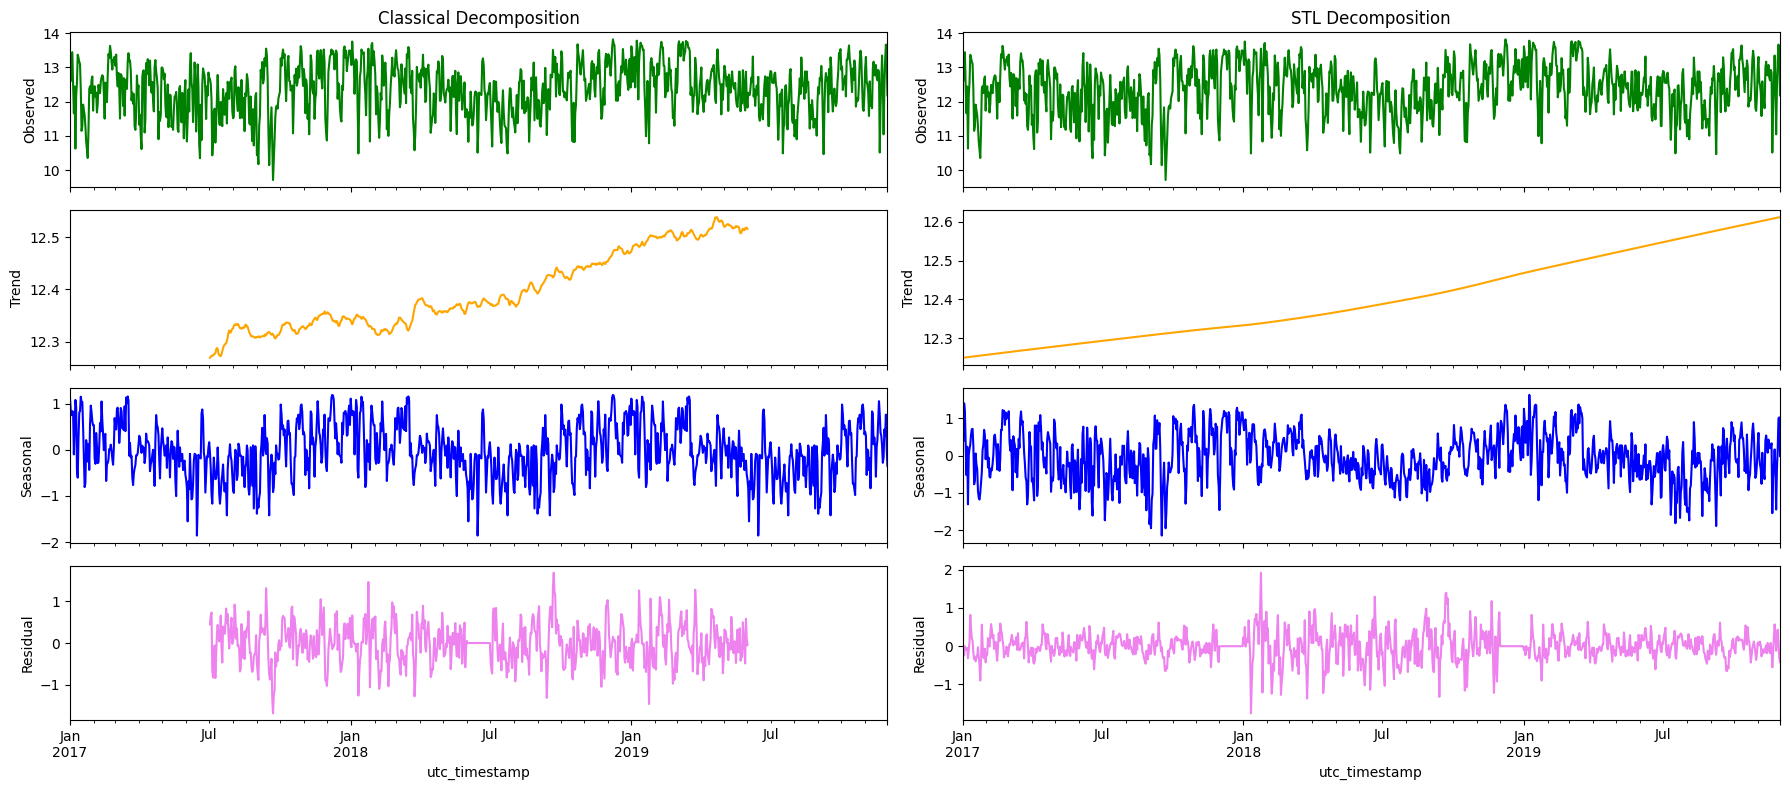

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Log-transformation
wind_gen_log_train = np.log(wind_gen_train)

# Classical Decomposition
classical_decomp = seasonal_decompose(wind_gen_log_train, model='additive', period=365)
# Decomposition STL
stl_decomp = STL(wind_gen_log_train, period=365).fit()

def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False, color='green')
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False, color='orange')
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False, color='blue')
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False, color='violet')
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(18,8))
plotseasonal(classical_decomp, axes[:,0])
axes[0,0].set_title('Classical Decomposition')
plotseasonal(stl_decomp, axes[:,1])
axes[0,1].set_title('STL Decomposition');
plt.tight_layout()
plt.show()


The decompositions reveal a clear upward **trend** in wind generation over time.

A yearly **seasonal** pattern is also observed, supporting the use of seasonal models.

**Residuals** appear relatively stable, suggesting that the log transformation effectively stabilized the variance

Both classical and STL decompositions identify a similar seasonal component and comparable residual behavior. However, STL provides a smoother and more flexible estimate of the trend.

## 3.2 Stationarity Tests

We applied three complementary tests on the **log-transformed wind generation series** to assess its stationarity:

### 3.2.1 - Augmented Dickey-Fuller (**ADF**)

In [ ]:
# Eseguo i test di stazionarietà
def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('--------------------------------------')

  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')


print('ADF on Wind_generation data')
adfuller_test(wind_gen_train)
print('--------------------------------------')

# p > 0.05 --> We cannot reject the null hypothesis (H0), meaning data the data has a unit root and is non-stationary.
# p <= 0.05 --> We reject the null hypothesis (H0), meaning data the data has not a unit root and is stationary.

ADF on Wind_generation data
ADF Statistic: -10.743227533298345
p-value:  2.7835746795209195e-19
--------------------------------------
We can reject the null hypothesis (H0) --> data is stationary
--------------------------------------


**ADF Test (Augmented Dickey-Fuller)**  
  - ADF → p-value <= 0.05  → We can reject the null hypothesis (H0), data is stationary.


### 3.2.2 - Kwiatkowski-Phillips-Schmidt-Shin Test (**KPSS**)

In [ ]:
# KPSS on the different data from previous examples
# Note: "regression" represents the null hypothesis for the KPSS test. There are two options:
# “c” : The data is stationary around a constant (default).
# “ct” : The data is stationary around a trend

def kpss_test_c(data):
  kpss_out = kpss(data,regression='c', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> unit root, data is not stationary in level')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is level - stationary')


print('KPSS (regression = c) on Wind_generation data')
kpss_test_c(wind_gen_train)
print('--------------------------------------')

KPSS (regression = c) on Wind_generation data
KPSS Statistic: 0.2991326221000555
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is level - stationary
--------------------------------------


In [ ]:
def kpss_test_ct(data):
  kpss_out = kpss(data,regression='ct', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> unit root, data is not trend stationary ')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')


print('KPSS (regression = ct) on Wind_generation data')
kpss_test_ct(wind_gen_train)
print('--------------------------------------')

KPSS (regression = ct) on Wind_generation data
KPSS Statistic: 0.15940730950138624
p-value:  0.03882724208217813
We can reject the null hypothesis (H0) --> unit root, data is not trend stationary 
--------------------------------------


We performed both level (`regression='c'`) and trend (`regression='ct'`) KPSS tests on the log-transformed series:

- **KPSS (level)** → p‑value < 0.05 → rejects level-stationarity  
- **KPSS (trend)** → p‑value > 0.05 → cannot reject trend-stationarity  

This indicates that the series is **not level-stationary**, but it is **trend-stationary**:  
(i.e., after removing a deterministic trend, the residuals are stationary.)  
Hence, a valid alternative to differencing could be **detrending**, but we will proceed with differencing for modeling simplicity and to ensure model stationarity.


## 3.3 - Seasonal Difference

In [ ]:
# Differenziazione stagionale (lag 365)
wind_gen_seasonal_diff_train = wind_gen_train.diff(365).dropna()

In [ ]:
# ADF Test
print('ADF on wind_gen_log_seasonal_diff')
adfuller_test(wind_gen_seasonal_diff_train)
print('--------------------------------------\n')

# KPSS Test
print('KPSS (regression = c) on Wind_generation_log data')
kpss_test_c(wind_gen_seasonal_diff_train)
print('--------------------------------------\n')

print('KPSS (regression = ct) on Wind_generation_log data')
kpss_test_ct(wind_gen_seasonal_diff_train)
print('--------------------------------------')

ADF on wind_gen_log_seasonal_diff
ADF Statistic: -13.785459415539965
p-value:  9.129929543712199e-26
--------------------------------------
We can reject the null hypothesis (H0) --> data is stationary
--------------------------------------

KPSS (regression = c) on Wind_generation_log data
KPSS Statistic: 0.05992738948684501
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is level - stationary
--------------------------------------

KPSS (regression = ct) on Wind_generation_log data
KPSS Statistic: 0.06491205315733156
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
--------------------------------------


These results confirm that the **seasonally differenced series is already stationary**.  
Hence, **no additional first-order differencing is required**, and we can proceed with ACF/PACF analysis.

## 3.4 - ACF & PACF

To identify suitable values for the ARIMA and seasonal ARIMA model parameters, we analyze the autocorrelation function (ACF) and the partial autocorrelation function (PACF) of the series after having applied seasonal differencing (lag 365).

These plots help us detect the presence of autoregressive (AR), moving average (MA), and seasonal components.

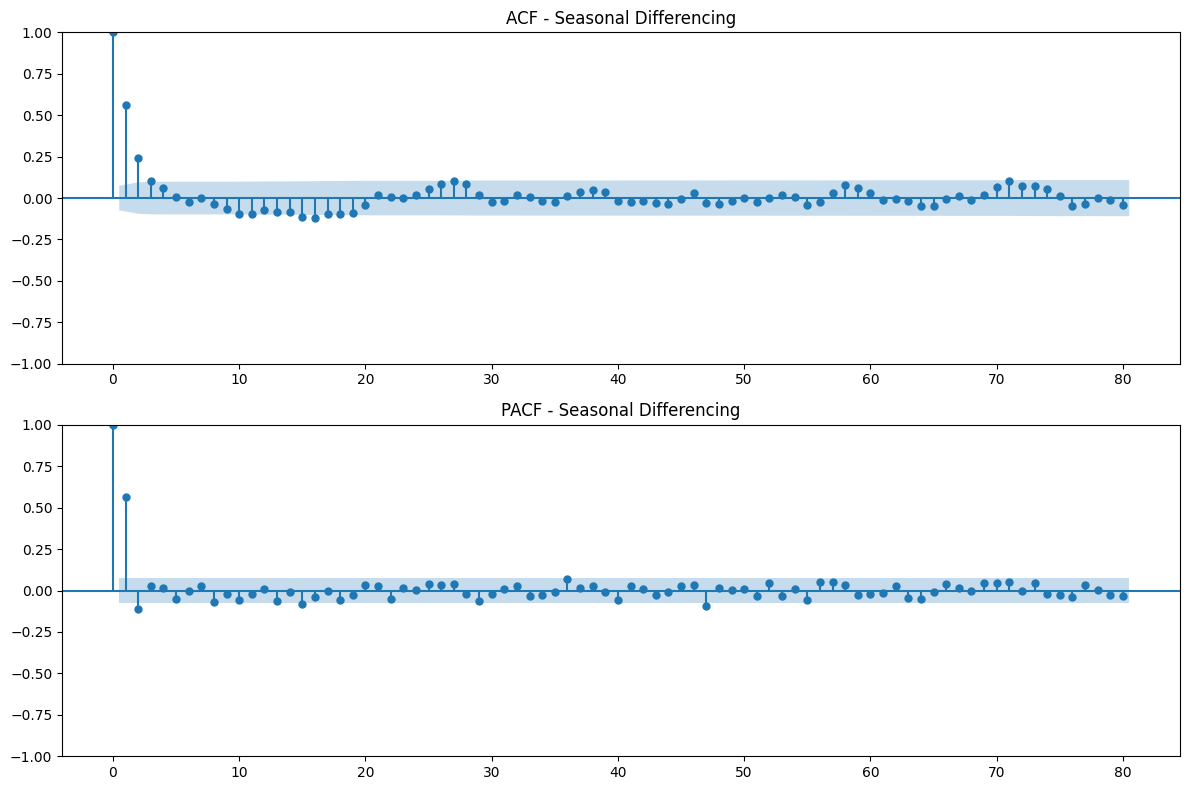

In [ ]:
# Plot ACF e PACF sulla serie log-differenziata stagionalmente
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(wind_gen_seasonal_diff_train, ax=axes[0], lags=80)
axes[0].set_title('ACF - Seasonal Differencing')

plot_pacf(wind_gen_seasonal_diff_train, ax=axes[1], method='ywm', lags=80)
axes[1].set_title('PACF - Seasonal Differencing')

plt.tight_layout()
plt.show()


- The ACF plot shows clear spikes at **lag 1 and 2**, suggesting a Moving Average component of order 2 (**MA(2)**).
- The PACF plot reveals a strong spike at **lag 1**, pointing to an Autoregressive component of order 1 (**AR(1)**), with minor spikes at lag 2 and others likely due to noise.

we don't have enough values to determine seasonal lags (and then parameters P,Q for SARIMA(p,d,q)(P,D,Q)[m]).

However, since applying .diff(365) successfully stabilized the series, we can assume d = 0 and D = 1, with a seasonal period m = 365.




#4 - Best Model Choiche

Choosing the appropriate model(s) to forecast the required data for the specified period. Evaluate the
model performance using different metrics. Visualise the results with appropriate graphs.

## 4.1 - Simple Forecasting Approaches
Several methods are currently available to forecast portion of data over a period, ranging from simple to more complex approaches each one with its own specific properties/applicability criteria. Besides linear regression, some forecasting methods are very simple though effective in different contexts. We can identify four simple forecasting methods that are generally used as benchmarks (*baseline methods*):


1. **Mean (average) method**: the forecasts of all future values are equal to the  average of the historical data;
2.  **Naive method:** all forecasts are set to be equal to the value of the last observation. This method works well for many economic and financial time series. As a naive forecast is optimal when data follow a random walk, these are also called *random walk forecasts*;
3. **Seasonal naive method:** similar to naive but useful for highly seasonal data. In this case, we set each forecast to be equal to the last observed value from the previous season;
4. **Drift method:** variation on the naïve method to allow the forecasts to increase or decrease over time. The amount of change over time (drift) is set to be the average change seen in the historical data.


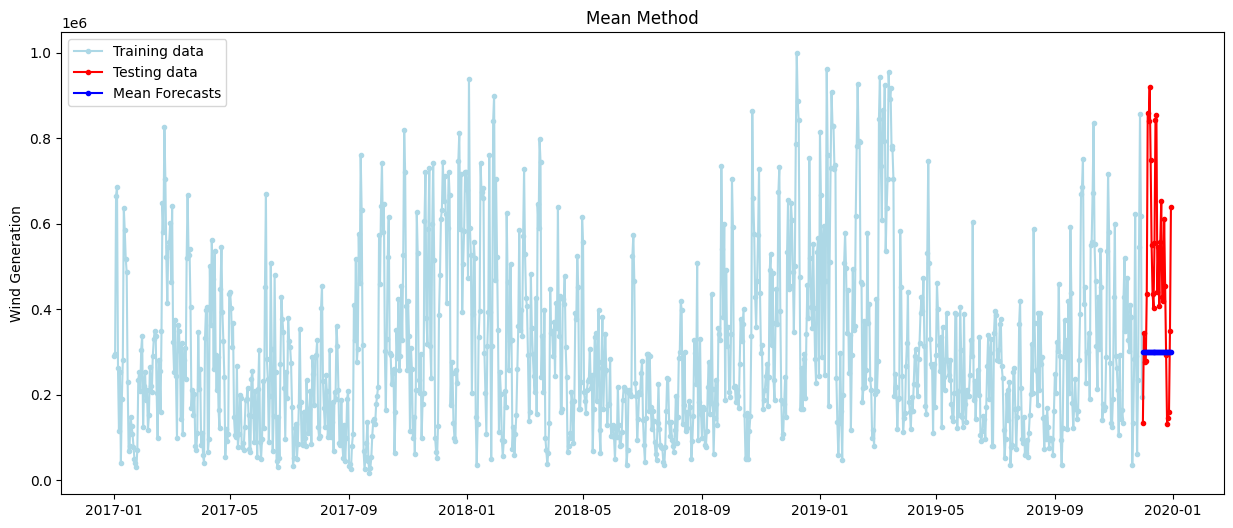

In [ ]:
from statsforecast.models import HistoricAverage

# 1) Mean method --> the forecasts of all future values are equal to the average of the historical data
model_mean = HistoricAverage()
model_mean = model_mean.fit(wind_gen_train)
forecast_values = model_mean.predict(len(wind_gen_test)) # we have to specify the forecasting horizon (i.e., how many points to forecast)

plt.figure(figsize=(15, 6))
plt.plot(wind_gen_train, color='lightblue',marker = '.',label='Training data')
plt.plot(wind_gen_test, color='red', marker = '.',label='Testing data')
plt.plot(wind_gen_test.index, forecast_values['mean'], color='blue', marker = '.', label='Mean Forecasts' )
plt.ylabel('Wind Generation')
plt.title('Mean Method')
plt.legend()
plt.show()

In [ ]:
# Metrics
mse = mean_squared_error(wind_gen_test, forecast_values['mean'])
rmse = np.sqrt(mse)

model_metrics = pd.DataFrame([{
    'Model': 'Mean Method',
    'MSE': mse,
    'RMSE': rmse
}])

model_metrics


Model           MSE           RMSE
0  Mean Method  8.729382e+10  295455.283941

RMSE = 295 455 → on average, forecasts deviate by ~295,000 MWh from true values


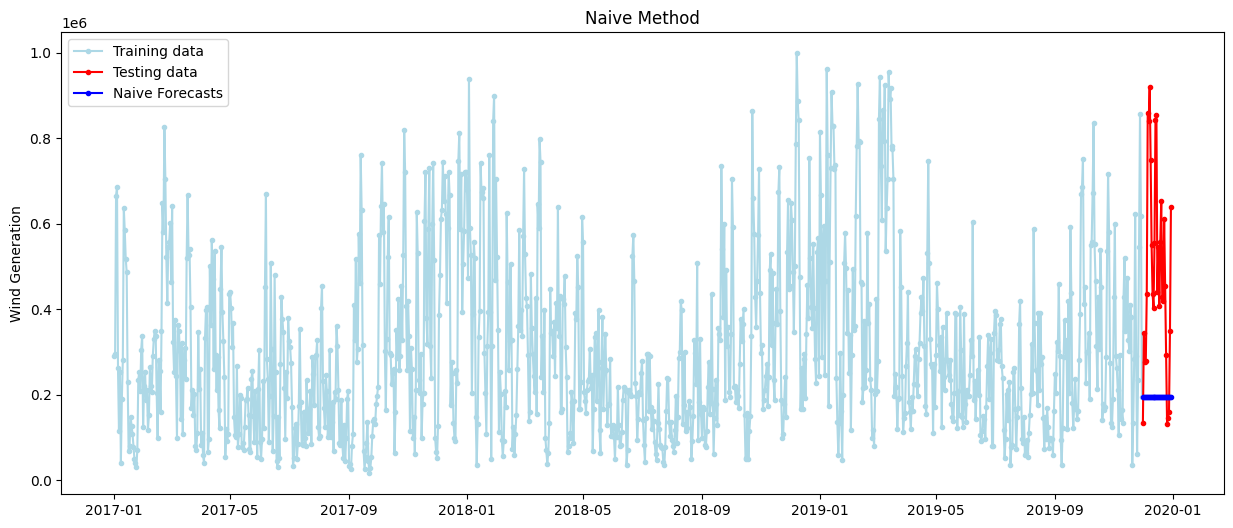

In [ ]:
# 2) Naive Method --> we simply set all forecasts to be the value of the last observation
model_naive = Naive()
model_naive = model_naive.fit(wind_gen_train)
forecast_values = model_naive.predict(len(wind_gen_test))

plt.figure(figsize=(15, 6))
plt.plot(wind_gen_train, color='lightblue',marker = '.',label='Training data')
plt.plot(wind_gen_test, color='red', marker = '.',label='Testing data')
plt.plot(wind_gen_test.index, forecast_values['mean'], color='blue', marker = '.', label='Naive Forecasts' )
plt.ylabel('Wind Generation')
plt.title('Naive Method')
plt.legend()
plt.show()

In [ ]:
# Metrics
mse = mean_squared_error(wind_gen_test, forecast_values['mean'])
rmse = np.sqrt(mse)

naive_row = pd.DataFrame([{
    'Model': 'Naive Method',
    'MSE': mse,
    'RMSE': rmse
}])

model_metrics = pd.concat([model_metrics, naive_row], ignore_index=True)
model_metrics


Model           MSE           RMSE
0   Mean Method  8.729382e+10  295455.283941
1  Naive Method  1.385870e+11  372272.698881

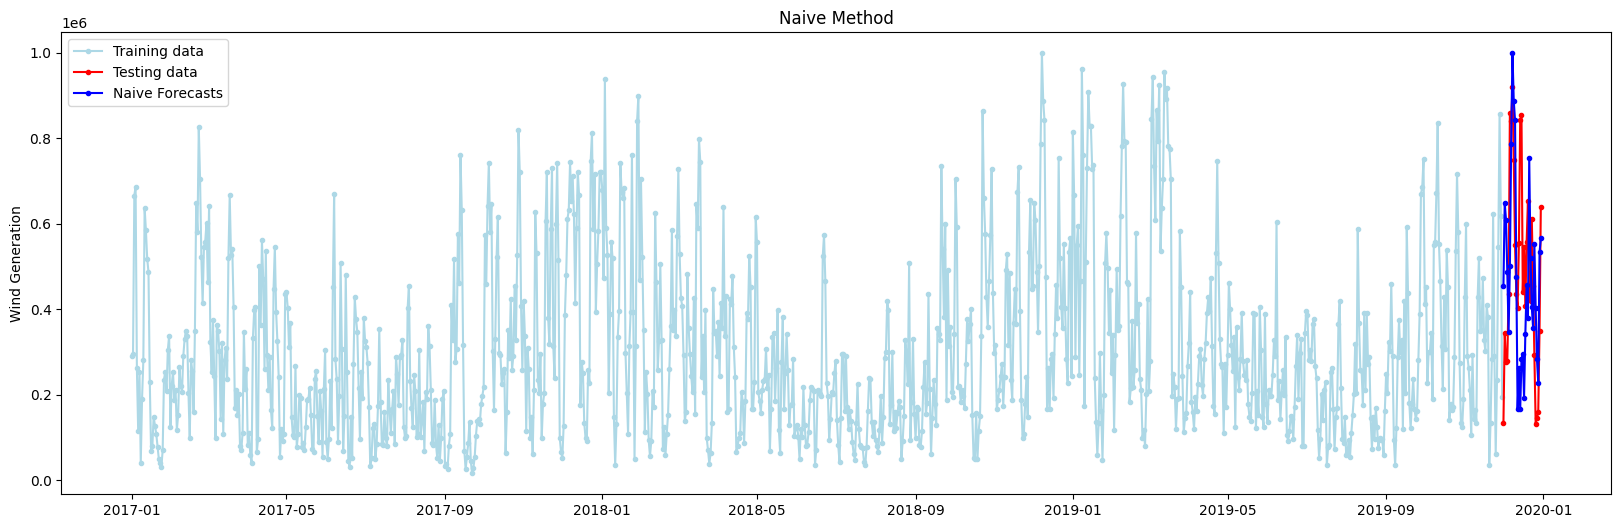

In [ ]:
# 3) Seasonal Naive Method --> similar to the naive, but uses the last known observation of the same period
model_seasonal_naive = SeasonalNaive(season_length=365) # seasonality has to be specified
model_seasonal_naive = model_seasonal_naive.fit(wind_gen_train)
forecast_values = model_seasonal_naive.predict(len(wind_gen_test))

plt.figure(figsize=(20, 6))
plt.plot(wind_gen_train, color='lightblue',marker = '.',label='Training data')
plt.plot(wind_gen_test, color='red', marker = '.',label='Testing data')
plt.plot(wind_gen_test.index, forecast_values['mean'], color='blue', marker = '.', label='Naive Forecasts' )
plt.ylabel('Wind Generation')
plt.title('Naive Method')
plt.legend()
plt.show()

In [ ]:
# Metrics
mse = mean_squared_error(wind_gen_test, forecast_values['mean'])
rmse = np.sqrt(mse)

Seasonal_naive_row = pd.DataFrame([{
    'Model': 'Seasonal Naive Method',
    'MSE': mse,
    'RMSE': rmse
}])

model_metrics = pd.concat([model_metrics, Seasonal_naive_row], ignore_index=True)
model_metrics

Model           MSE           RMSE
0            Mean Method  8.729382e+10  295455.283941
1           Naive Method  1.385870e+11  372272.698881
2  Seasonal Naive Method  7.110273e+10  266650.946834

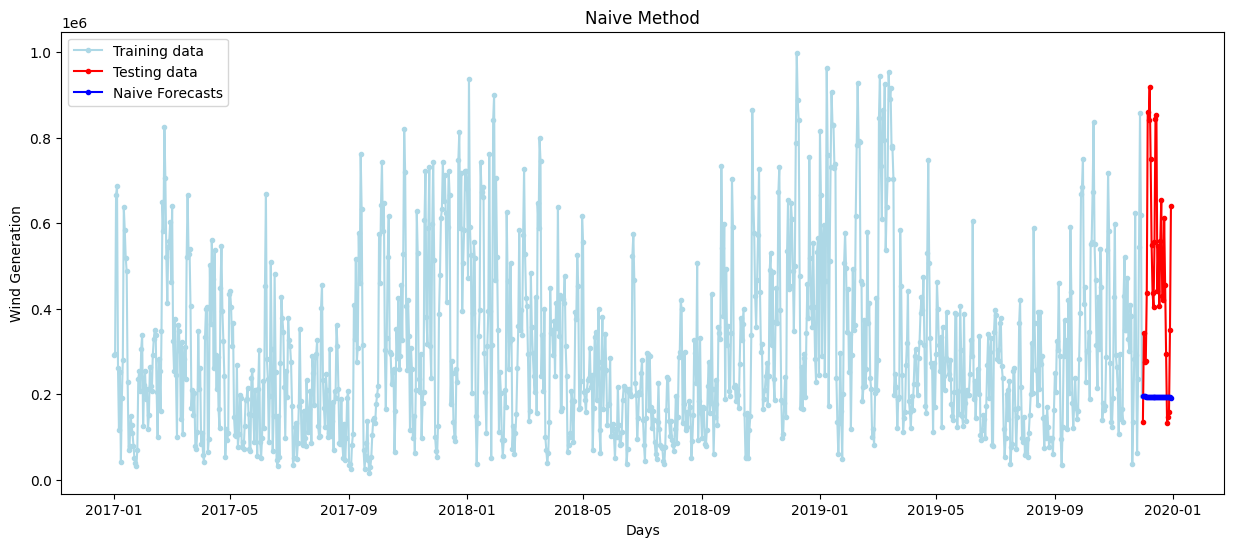

In [ ]:
# 4) Drift Method --> variation on Naive, it allows the forecasts to increase or decrease over time (amout of change is called drift)
model_drift = RandomWalkWithDrift()
model_drift = model_drift.fit(wind_gen_train)
forecast_values = model_drift.predict(len(wind_gen_test))

plt.figure(figsize=(15, 6))
plt.plot(wind_gen_train, color='lightblue',marker = '.',label='Training data')
plt.plot(wind_gen_test, color='red', marker = '.',label='Testing data')
plt.plot(wind_gen_test.index, forecast_values['mean'], color='blue', marker = '.', label='Naive Forecasts' )
plt.xlabel('Days')
plt.ylabel('Wind Generation')
plt.title('Naive Method')
plt.legend()
plt.show()

In [ ]:
# Metrics
mse = mean_squared_error(wind_gen_test, forecast_values['mean'])
rmse = np.sqrt(mse)

Drift_row = pd.DataFrame([{
    'Model': 'Drift Method',
    'MSE': mse,
    'RMSE': rmse
}])

model_metrics = pd.concat([model_metrics, Drift_row], ignore_index=True)
model_metrics.set_index('Model', inplace=True)
model_metrics

MSE           RMSE
Model                                             
Mean Method            8.729382e+10  295455.283941
Naive Method           1.385870e+11  372272.698881
Seasonal Naive Method  7.110273e+10  266650.946834
Drift Method           1.393505e+11  373296.846764

Among the four benchmark methods, the **Seasonal Naive** performs better among the four, achieving the lowest RMSE.

This outcome is consistent with expectations, given the strong seasonal structure in the data, which the method captures by repeating the value from the same time in the previous year.

The other three methods perform worse than the Seasonal Naive. The **Mean method** shows moderate accuracy by averaging past values, while the **Naive** and **Drift** methods underperform due to their inability to account for seasonality.

## 4.2 - Exponential Smoothing Models (ETS)

 Forecasts produced using exponential smoothing methods (generally known as "ETS models", where E indicates error, T trend and S seasonality) are weighted averages of past observations, with the weights decaying exponentially as the observations get older. Briefly, the more recent the observation is, the higher the associated weight. This framework quickly generates reliable forecasts for a wide range of time series.

Since Simple Exponential Smoothing (SES) is suitable for forecasting data with no clear trend or seasonal pattern. I won't do it because I don't expect this to work well on our data, since we have seen that the data has a seasonal pattern.

Same reasoning for Double Exponential Smoothing (DES) since this model consider trends but not seasonality.

**Weekly Aggregation & Changing Of Training Test Size**

In order to make the comparison between ETS and SARIMA models more robust, I decided to aggregate the daily wind generation data to a weekly frequency. This allows us to work with a more manageable seasonal period (s = 52 weeks), instead of using s = 365 days, which can be problematic and computationally expensive for SARIMA models.

Since the original test period (December 2019) would only include 4–5 weekly observations after aggregation, I extended the test set to include a few additional weeks to ensure a more reliable evaluation of model performance.





In [ ]:
# Aggregazione settimanale
df_weekly = df.resample('W').mean()

# Training e test split
train_weekly = df_weekly['wind_generation'][:-14]
test_weekly = df_weekly['wind_generation'][-14:]
display(train_weekly.tail())
display(test_weekly.head())

utc_timestamp
2019-09-01 00:00:00+00:00    119586.714286
2019-09-08 00:00:00+00:00    244618.285714
2019-09-15 00:00:00+00:00    278667.571429
2019-09-22 00:00:00+00:00    278723.000000
2019-09-29 00:00:00+00:00    356641.000000
Freq: W-SUN, Name: wind_generation, dtype: float64

utc_timestamp
2019-10-06 00:00:00+00:00    398423.857143
2019-10-13 00:00:00+00:00    546193.428571
2019-10-20 00:00:00+00:00    342129.714286
2019-10-27 00:00:00+00:00    376999.142857
2019-11-03 00:00:00+00:00    291519.285714
Freq: W-SUN, Name: wind_generation, dtype: float64

**Triple Exponential Smoothing (TES)**

It extends Holt’s method to capture seasonality, comprising the forecast equation and three smoothing equations (level, trend and seasonality).

### 4.2.1 - Triple Exponential Smoothing

In [ ]:
# Additive ETS Model
model_TES = ETSModel(train_weekly, error='add', trend='add', seasonal='add', seasonal_periods=52).fit()

# Predictions
pred = model_TES.get_prediction(start=test_weekly.index[0], end=test_weekly.index[-1])
df_TES = pred.summary_frame()
forecasts = df_TES['mean']

# Estimated Parameters
tab = pd.DataFrame({
    'Param Name': model_TES.param_names,
    'Values': model_TES.params
})
tab

Param Name         Values
0       smoothing_level       0.033061
1       smoothing_trend       0.001038
2    smoothing_seasonal       0.469463
3         initial_level  279150.870238
4         initial_trend    2288.433879
5    initial_seasonal.0  265226.759615
6    initial_seasonal.1  203787.265110
7    initial_seasonal.2  -35997.962912
8    initial_seasonal.3  142778.505494
9    initial_seasonal.4  101013.229395
10   initial_seasonal.5  137444.684066
11   initial_seasonal.6 -128067.604396
12   initial_seasonal.7  -38339.493132
13   initial_seasonal.8  -67451.167582
14   initial_seasonal.9  147517.973900
15  initial_seasonal.10  -56052.697802
16  initial_seasonal.11  175070.471154
17  initial_seasonal.12 -136491.770604
18  initial_seasonal.13  -55063.002748
19  initial_seasonal.14   27972.524725
20  initial_seasonal.15  -37992.712912
21  initial_seasonal.16 -199910.398352
22  initial_seasonal.17   -4932.494506
23  initial_seasonal.18  -26900.059066
24  initial_seasonal.19 -111741.921703
25  initial_seasonal.20 -102521.381868
26  initial_seasonal.21  -94003.634616
27  initial_seasonal.22 -199014.605769
28  initial_seasonal.23 -218697.342033
29  initial_seasonal.24 -174618.947802
30  initial_seasonal.25    3177.820055
31  initial_seasonal.26  -62433.829670
32  initial_seasonal.27 -202404.585165
33  initial_seasonal.28 -162139.703297
34  initial_seasonal.29 -173975.791209
35  initial_seasonal.30  -87747.748626
36  initial_seasonal.31 -110140.269231
37  initial_seasonal.32 -168136.800824
38  initial_seasonal.33 -130238.770604
39  initial_seasonal.34 -216778.748626
40  initial_seasonal.35 -241910.082417
41  initial_seasonal.36  -44178.082418
42  initial_seasonal.37   70850.800824
43  initial_seasonal.38 -275567.377747
44  initial_seasonal.39 -177400.269231
45  initial_seasonal.40  224808.442308
46  initial_seasonal.41   10266.581044
47  initial_seasonal.42  -80002.766483
48  initial_seasonal.43  149251.649725
49  initial_seasonal.44  -37329.322802
50  initial_seasonal.45  -65847.229396
51  initial_seasonal.46  -11085.171703
52  initial_seasonal.47  110100.765110
53  initial_seasonal.48  -58898.869505
54  initial_seasonal.49  295031.016483
55  initial_seasonal.50  103613.163462
56  initial_seasonal.51       0.000000

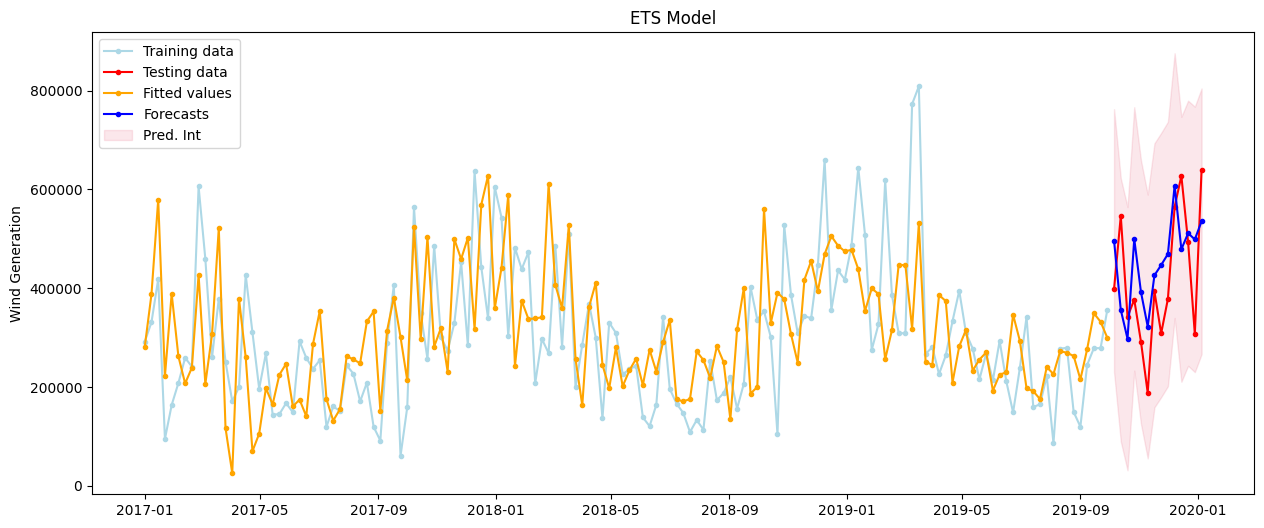

In [ ]:
# Visualization
plt.figure(figsize=(15,6))
plt.plot(train_weekly, color='lightblue',marker = '.',label='Training data')
plt.plot(test_weekly, color='red', marker = '.',label='Testing data')
plt.plot(model_TES.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='blue', marker = '.', label='Forecasts')
plt.fill_between(df_TES.index, df_TES['pi_lower'], df_TES['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.ylabel('Wind Generation')
plt.title('ETS Model')
plt.legend()
plt.show()

In [ ]:
# Calcolo e salvo l'AIC del modello ETS settimanale
aic_ets_weekly = model_TES.aic

# Creo DataFrame con il risultato
ets_metrics = pd.DataFrame([{
    'Model': 'ETS Weekly ',
    'AIC': aic_ets_weekly,
    'RMSE': np.sqrt(mean_squared_error(test_weekly, forecasts)),
    'MAE': mean_absolute_error(test_weekly, forecasts),
    'MAPE (%)': mean_absolute_percentage_error(test_weekly, forecasts)
}])

ets_metrics


Model          AIC           RMSE            MAE  MAPE (%)
0  ETS Weekly   3928.529231  116867.610549  104052.571275  0.286875


Metrics:

- **AIC (Akaike Information Criterion):** Measures the trade-off between model fit and complexity. Lower is better.
- **RMSE (Root Mean Squared Error):** Indicates how much forecasts deviate, on average.
- **MAE (Mean Absolute Error):** Measures the average absolute difference between predictions and actual values.
- **MAPE (Mean Absolute Percentage Error):** Expresses forecast accuracy as a percentage.




### 4.2.2 - Damped Triple Exponential Smoothing

In [ ]:
# Additive ETS Model Damped
model_TES_damped = ETSModel(train_weekly, error='add', trend='add', seasonal='add', seasonal_periods=52, damped_trend=True).fit()

# Predictions
pred_damped = model_TES_damped.get_prediction(start=test_weekly.index[0], end=test_weekly.index[-1])
df_TES_damped = pred_damped.summary_frame()
forecasts_damped = df_TES_damped['mean']

# Estimated Parameters
tab = pd.DataFrame({
    'Param Name': model_TES_damped.param_names,
    'Values': model_TES_damped.params
})
tab



Param Name        Values
0       smoothing_level  1.000000e-04
1       smoothing_trend  1.000000e-08
2    smoothing_seasonal  4.659515e-01
3         damping_trend  9.747085e-01
4         initial_level  2.791509e+05
5         initial_trend  2.288434e+03
6    initial_seasonal.0  2.652268e+05
7    initial_seasonal.1  2.037873e+05
8    initial_seasonal.2 -3.599796e+04
9    initial_seasonal.3  1.427785e+05
10   initial_seasonal.4  1.010132e+05
11   initial_seasonal.5  1.374447e+05
12   initial_seasonal.6 -1.280676e+05
13   initial_seasonal.7 -3.833949e+04
14   initial_seasonal.8 -6.745117e+04
15   initial_seasonal.9  1.475180e+05
16  initial_seasonal.10 -5.605270e+04
17  initial_seasonal.11  1.750705e+05
18  initial_seasonal.12 -1.364918e+05
19  initial_seasonal.13 -5.506300e+04
20  initial_seasonal.14  2.797252e+04
21  initial_seasonal.15 -3.799271e+04
22  initial_seasonal.16 -1.999104e+05
23  initial_seasonal.17 -4.932495e+03
24  initial_seasonal.18 -2.690006e+04
25  initial_seasonal.19 -1.117419e+05
26  initial_seasonal.20 -1.025214e+05
27  initial_seasonal.21 -9.400363e+04
28  initial_seasonal.22 -1.990146e+05
29  initial_seasonal.23 -2.186973e+05
30  initial_seasonal.24 -1.746189e+05
31  initial_seasonal.25  3.177820e+03
32  initial_seasonal.26 -6.243383e+04
33  initial_seasonal.27 -2.024046e+05
34  initial_seasonal.28 -1.621397e+05
35  initial_seasonal.29 -1.739758e+05
36  initial_seasonal.30 -8.774775e+04
37  initial_seasonal.31 -1.101403e+05
38  initial_seasonal.32 -1.681368e+05
39  initial_seasonal.33 -1.302388e+05
40  initial_seasonal.34 -2.167787e+05
41  initial_seasonal.35 -2.419101e+05
42  initial_seasonal.36 -4.417808e+04
43  initial_seasonal.37  7.085080e+04
44  initial_seasonal.38 -2.755674e+05
45  initial_seasonal.39 -1.774003e+05
46  initial_seasonal.40  2.248084e+05
47  initial_seasonal.41  1.026658e+04
48  initial_seasonal.42 -8.000277e+04
49  initial_seasonal.43  1.492516e+05
50  initial_seasonal.44 -3.732932e+04
51  initial_seasonal.45 -6.584723e+04
52  initial_seasonal.46 -1.108517e+04
53  initial_seasonal.47  1.101008e+05
54  initial_seasonal.48 -5.889887e+04
55  initial_seasonal.49  2.950310e+05
56  initial_seasonal.50  1.036132e+05
57  initial_seasonal.51  0.000000e+00

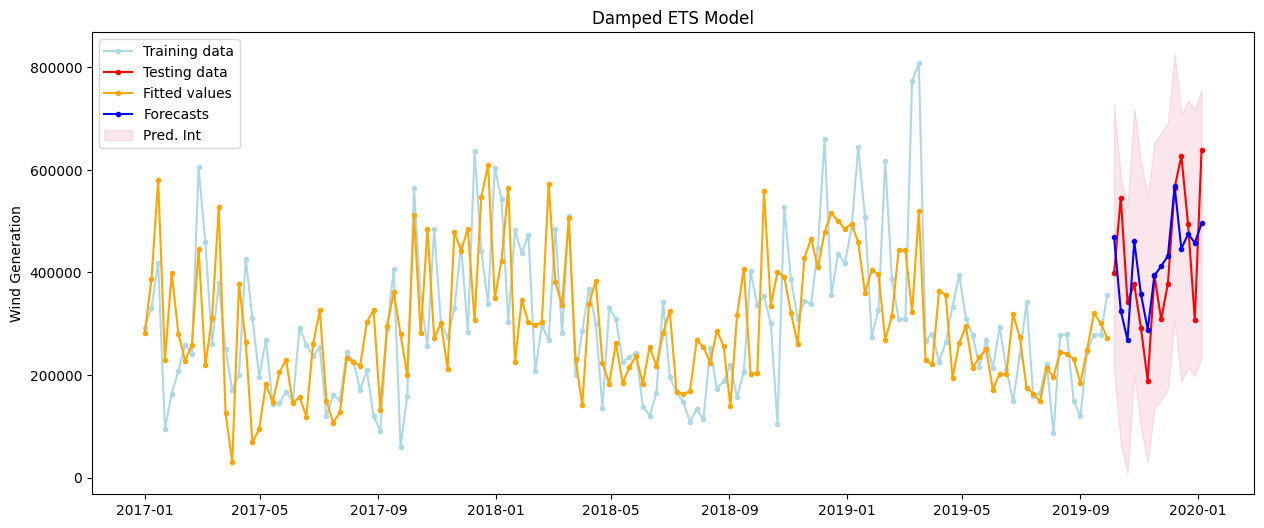

In [ ]:
# Visualization
plt.figure(figsize=(15,6))
plt.plot(train_weekly, color='lightblue',marker = '.',label='Training data')
plt.plot(test_weekly, color='red', marker = '.',label='Testing data')
plt.plot(model_TES_damped.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts_damped, color='blue', marker = '.', label='Forecasts')
plt.fill_between(df_TES_damped.index, df_TES_damped['pi_lower'], df_TES_damped['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.ylabel('Wind Generation')
plt.title('Damped ETS Model')
plt.legend()
plt.show()

In [ ]:
# Calcolo e salvo l'AIC del modello ETS settimanale
aic_ets_damped_weekly = model_TES_damped.aic

# Creo DataFrame con il risultato
ets_metrics_damped = pd.DataFrame([{
    'Model': 'Damped ETS Weekly ',
    'AIC': aic_ets_damped_weekly,
    'RMSE': np.sqrt(mean_squared_error(test_weekly, forecasts_damped)),
    'MAE': mean_absolute_error(test_weekly, forecasts_damped),
    'MAPE (%)': mean_absolute_percentage_error(test_weekly, forecasts_damped)
}])

ets_metrics= pd.concat([ets_metrics, ets_metrics_damped], ignore_index=True)
ets_metrics


Model          AIC           RMSE            MAE  MAPE (%)
0         ETS Weekly   3928.529231  116867.610549  104052.571275  0.286875
1  Damped ETS Weekly   3923.621884  110534.635879   90815.901091  0.236406

Given the limited test period, both **ETS** and **Damped ETS** show similar performance. However, the Damped ETS achieves slightly lower error metrics and AIC, suggesting a better fit.

Over longer forecasting horizons, the damping effect would likely provide greater stability and prevent over-forecasts.



Residuals Plotting for ETS


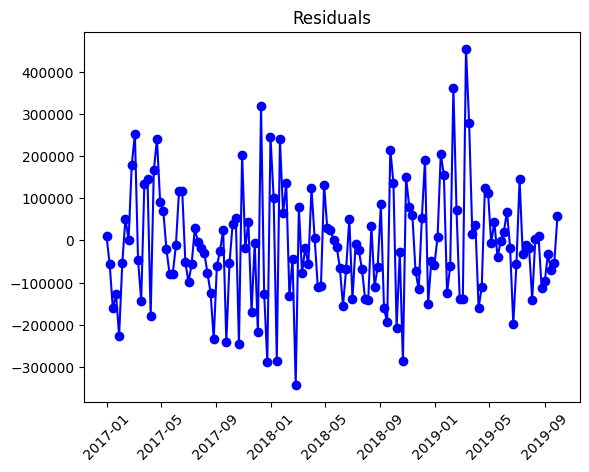

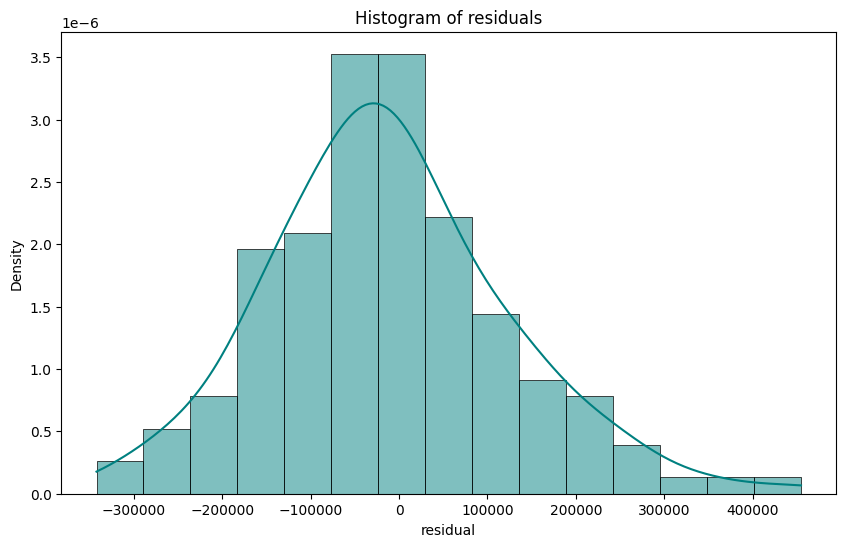

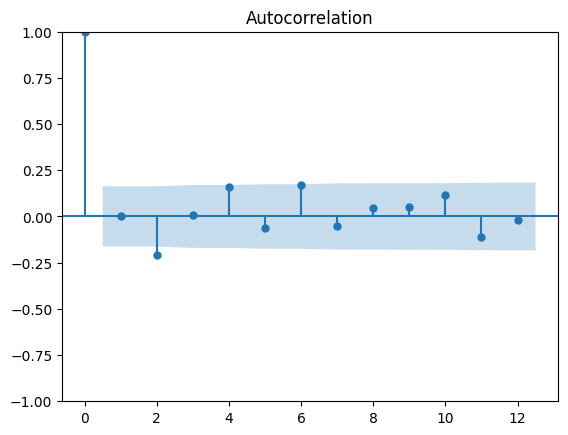

In [ ]:
# 4) Visualise the residuals for ETS (plot, histogram and ACF plot)
# Plot
plt.plot(model_TES.resid,'o-b');
plt.title('Residuals')
plt.xticks(rotation=45)  # ruota le etichette di 45 gradi

# Histogram of the residuals
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(x=model_TES.resid, stat='density', linewidth=0.5, kde=True,color='teal',bins=15)
ax.set(title='Histogram of residuals', xlabel='residual');

# ACF plot
plot_acf(model_TES.resid,lags=12);

The residuals are centered around zero, approximately normally distributed, and show no significant autocorrelation.  
This suggests the ETS model is well specified and captures the main structure of the data.


## 4.3 - SARIMA

We selected the SARIMA model over ARMA and ARIMA because the wind generation data exhibits both non-stationarity and strong seasonal patterns with a period of 52 weeks.  
Unlike ARMA (which assumes stationarity) or standard ARIMA (which lacks seasonal components), SARIMA can effectively capture these features.  


**1.1. Box-Jenkins method**

When dealing with the family of ARIMA models, it is important to remember the **Box-Jenkins methodology**  to find the best model. This refers to a systematic method of identifying, fitting, checking, and using ARIMA models built for time series forecasting. the process includes the following steps:

**1.   Model Identification:** as first step, it is important to verify the stationarity, determine if our time series is seasonal and find the seasonal period, and eventually apply appropriate transformations to reduce the variance (e.g., logarithm). When data have a strong seasonal pattern, seasonal differencing should be used as first step. Once stationarity and seasonality have been addressed, the next step is to identify the order (p,d,q) of ARIMA models in order to capture the salient dynamic features
of the data. This is usually done by relying on ACF/PACF plots or on grid search;

**2.   Model estimation:**  Once the model order has been identified, the model parameter are estimated generally using maximum likelihood estimation. Appropriate criteria, such as AIC, AICc and BIC, have to be used to compare and select the best model;

**3.   Model diagnostic:** After fitting the model on the train data, conduct goodness-of-fit checks to ensure the model describes the data adequately. In particular the residuals are taken and it is assessed whether they are white noise and they are normally distributed. ACF plot of the residuals can help in this respect, along with statistical tests as the Ljung-Box test.
If the assumed model is appropriate for the data, the residuals should satisfy these assumptions. If they are not satisfied, we have to go back to the model identification step and try to develop a better model;

**4.   Forecasting:** If the model is good, we can finally perform the forecasting analyses in the separate test set, and perform all the performance evalutations (e.g., MAE, MSE/RMSE, MAPE, R2).

the Box-Jenkins methodology extends also to the seasonal ARIMA models (**SARIMA**).


These are generally written as ARIMA(p,d,q)(P,D,Q)m where the first part (p,d,q) refers to the non-seasonal component, while the second one (P,D,Q)m to the seasonal component. The term m refers to the seasonality.


ACF and PACF plots can help in identifying not only the non-seasonal component but also the seasonal part of an AR or MA model by looking at the seasonal lags of the PACF and ACF.


In our case, we already done seasonal differencing once in section 3.3, so d=0 and D=1. We have to find p, q, P and Q.

From the previous frequency analysis on the daily data, we estimated a seasonal period of m = 52, corresponding to weekly seasonality over a 365-day cycle. We will verify this assumption again after aggregating the data weekly to ensure consistency.

**1.   Model Identification:**

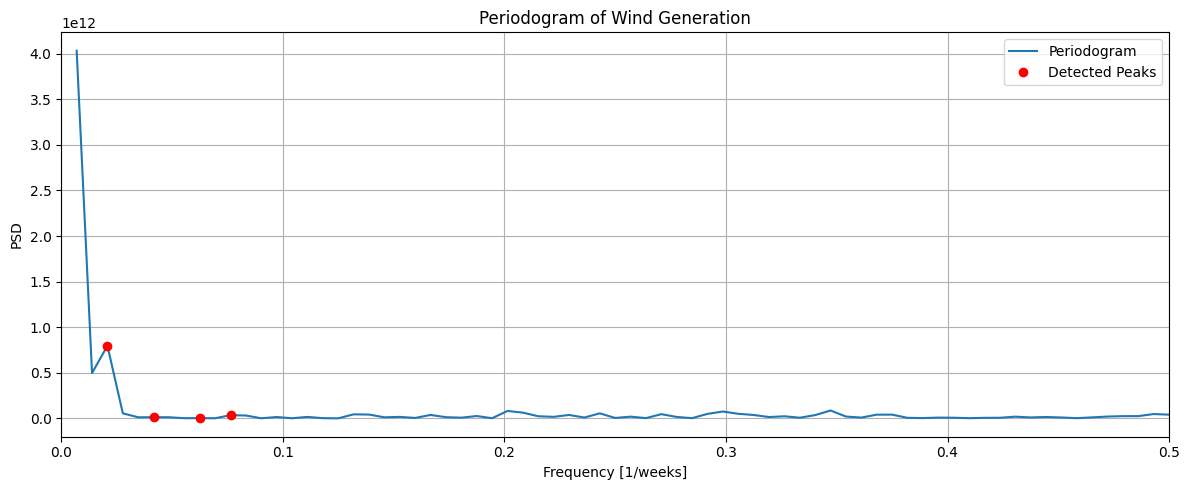

Detected Seasonalities: (Periods > 10 weeks)



Frequency [1/weeks]       Density  Period [weeks]
0             0.020833  7.964970e+11       48.000000
1             0.041667  1.276157e+10       24.000000
2             0.062500  3.040578e+09       16.000000
3             0.076389  3.521008e+10       13.090909
4             0.097222  1.457124e+10       10.285714

In [ ]:
f_per, Pxx_per = signal.periodogram(train_weekly, fs=1, detrend=None, window='hann', return_onesided=True, scaling='density')

f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

peaks = signal.find_peaks(Pxx_per, prominence=100000)[0]

peak_freq = f_per[peaks]
peak_dens = Pxx_per[peaks]
peak_periods = 1 / peak_freq

df_peaks = pd.DataFrame({'Frequency [1/weeks]': peak_freq, 'Density': peak_dens, 'Period [weeks]': peak_periods})
df_peaks = df_peaks[df_peaks['Period [weeks]']>10]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(f_per, Pxx_per, label='Periodogram')
plt.plot(peak_freq[:4], peak_dens[:4], 'ro', label='Detected Peaks')
plt.xlabel('Frequency [1/weeks]')
plt.ylabel('PSD')
plt.title('Periodogram of Wind Generation')
plt.grid(True)
plt.xlim(0, 0.5)
plt.legend()
plt.tight_layout()
plt.show()



print("Detected Seasonalities: (Periods > 10 weeks)\n")
display(df_peaks)

This discrepancy is likely due to the reduced length of the training set, which includes fewer complete seasonal cycles compared to the full dataset.

To maintain consistency and interpretability, we confirm Seasonality = 52 also for weekly aggregated data.

In [ ]:
# Differencing to remove seasonality

weekly_train_diff = train_weekly.diff(52).dropna()

We now plot the ACF and PACF of the weekly aggregated series to guide the selection of the non-seasonal and seasonal AR and MA orders (p, q, P, Q).

<Figure size 1000x400 with 0 Axes>

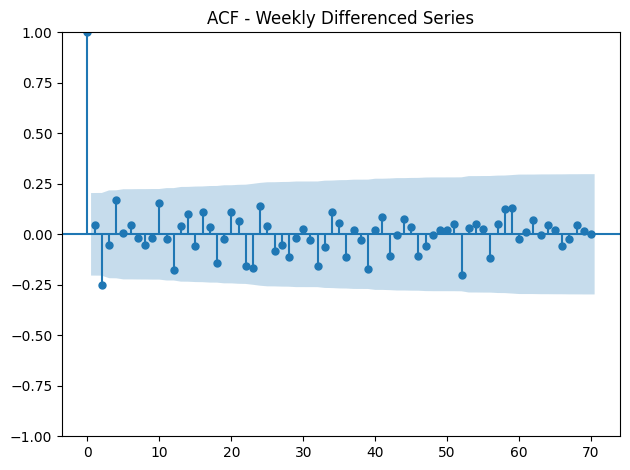

In [ ]:
#ACF plot
plt.figure(figsize=(10, 4))
plot_acf(weekly_train_diff, lags=70)
plt.title("ACF - Weekly Differenced Series")
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

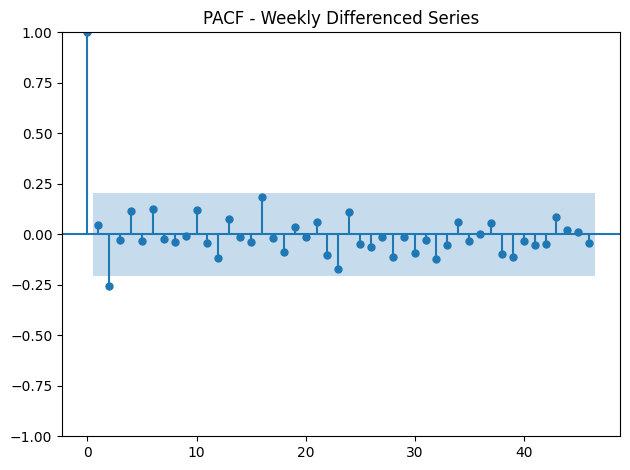

In [ ]:
plt.figure(figsize=(10, 4))
plot_pacf(weekly_train_diff, lags=46)
plt.title("PACF - Weekly Differenced Series")
plt.tight_layout()
plt.show()

- The ACF plot shows a little spike at **lag 2**, suggesting a Moving Average component of order 2 -> **MA(2)**.
- The PACF plot also shows a little spike at **lag 2**, indicating an Autoregressive component of order 2 -> **AR(2)**.
- We don't see spike at **lag 52** for ACF plot (seasonal lag). Therefore, we can't include a **seasonal AR term -> (Q=0)**.

- Unfortunately, since the PACF plot is limited to **lag 46**, we do **not have enough information** to evaluate the presence of a **seasonal MA component**. For now, we assume **P = 0**.


Based on these observations, the suggested model is:  
**SARIMA(2, 0, 2)(0, 1, 0)[52]**

This model assumes:
- **d = 0**, since we already applied seasonal differencing;
- **D = 1** and **seasonality m = 52**, based on weekly data with yearly seasonality;



**2. Model estimation:**

###4.3.1 - MANUAL SARIMA

In [ ]:
# Parametri
p, d, q = 2, 0, 2
P, D, Q, S = 0, 1, 0, 52

# Fit del modello
model_SARIMA_1 = SARIMAX(
    train_weekly,
    order=(p, d, q),
    seasonal_order=(P, D, Q, S),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result_SARIMA_1 = model_SARIMA_1.fit()

# Riassunto
print(result_SARIMA_1.summary())


                                      SARIMAX Results                                      
Dep. Variable:                     wind_generation   No. Observations:                  144
Model:             SARIMAX(2, 0, 2)x(0, 1, [], 52)   Log Likelihood               -1185.071
Date:                             Tue, 17 Jun 2025   AIC                           2380.143
Time:                                     19:00:01   BIC                           2392.586
Sample:                                 01-01-2017   HQIC                          2385.158
                                      - 09-29-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0368      0.449      0.082      0.935      -0.844       0.917
ar.L2         -0.4673      

**3. Model Diagnostics:**

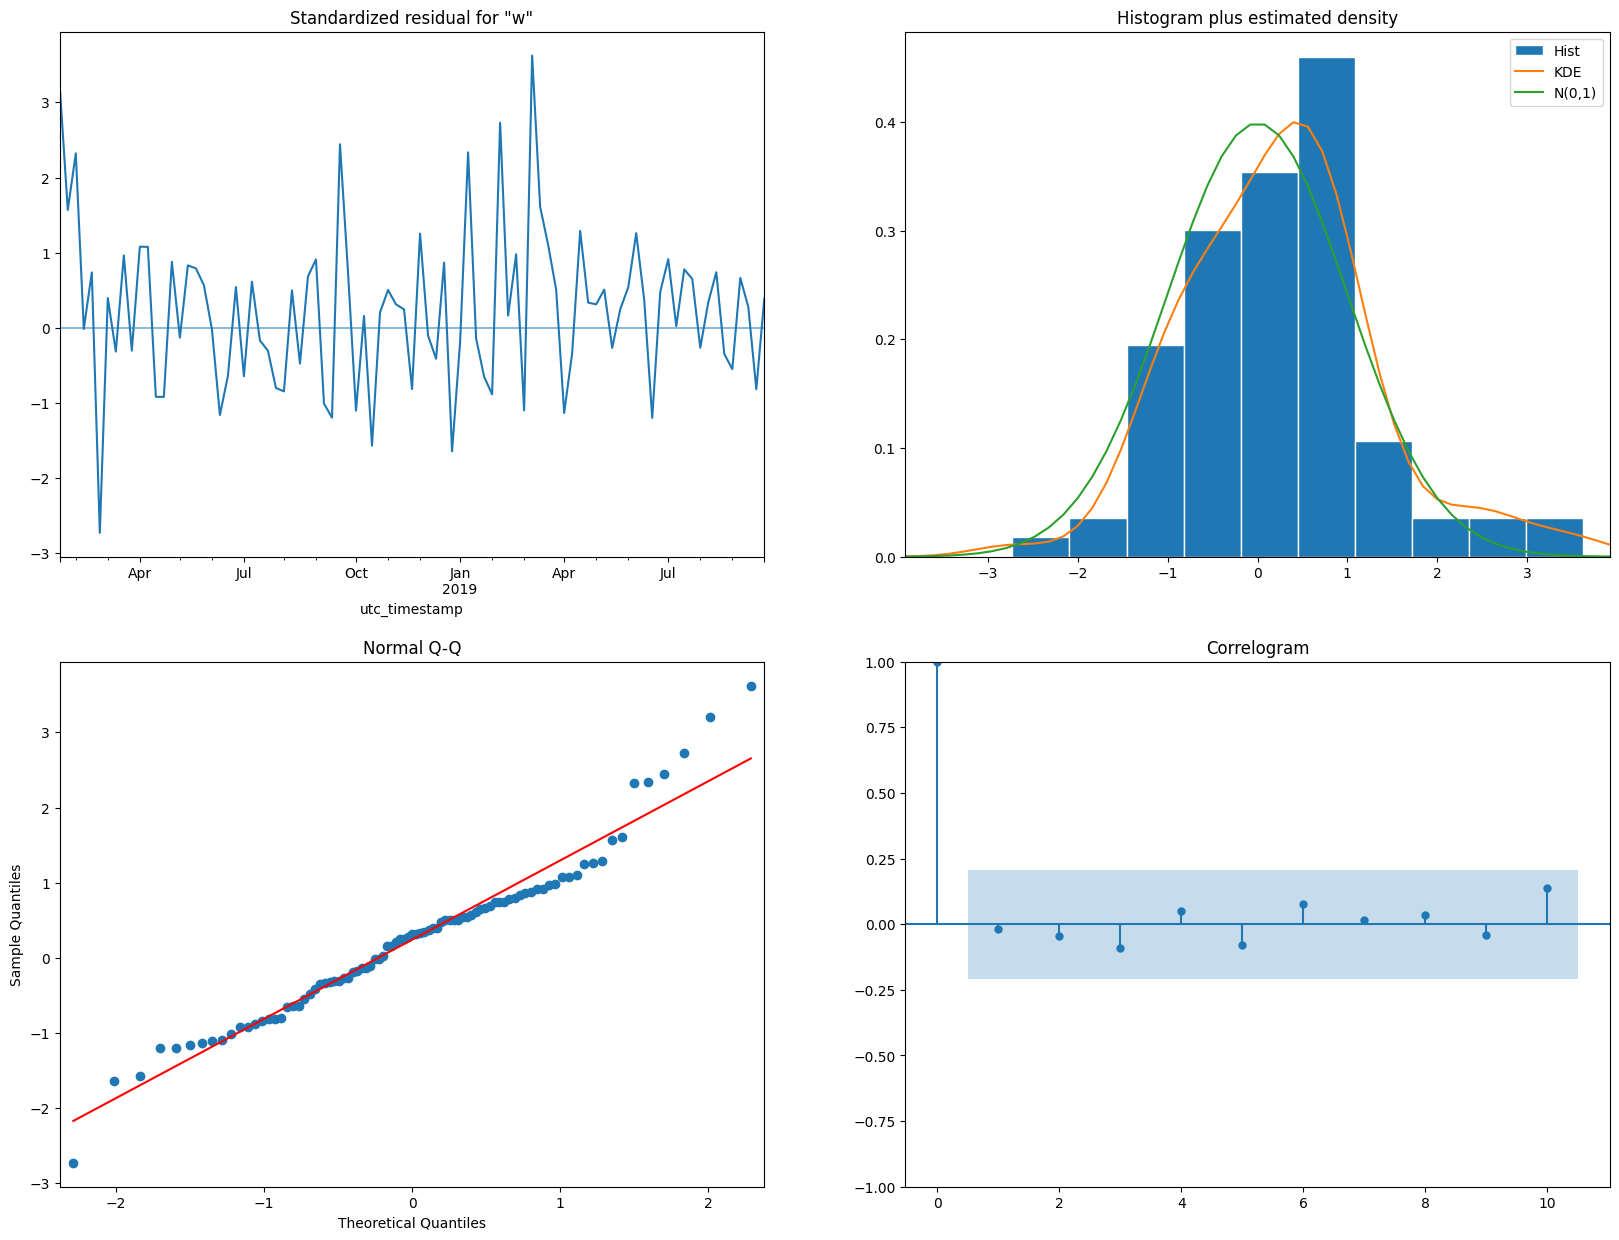

In [ ]:
result_SARIMA_1.plot_diagnostics(figsize=(20, 15));
plt.show()

The residual diagnostics seems to indicate that the model fits the data well.

The standardized residuals are centered around zero with no clear autocorrelation, as confirmed by the correlogram. The residuals are approximately normally distributed, although some deviations are present in the tails.

We'll try to check if residuals are good also with statistical test.


**Ljung-Box test**

It tests for the presence of autocorrelation in the residuals.

If lb_pvalue > 0.05, there is no significant autocorrelation (the residuals behave as white noise). The null hypothesis is accepted.

Otherwise, if the p-value is ≤ 0.05, the residuals are autocorrelated and the null hypothesis is rejected.

In [ ]:
print('Ljung-Box test: ')
ljung_test = acorr_ljungbox(result_SARIMA_1.resid, period=52)
ljung_test.head()

Ljung-Box test: 


lb_stat     lb_pvalue
1   36.803857  1.306315e-09
2   69.885946  6.675128e-16
3  102.397323  4.742082e-22
4  138.422426  6.142690e-29
5  161.460017  4.834630e-33

Null hypothesis rejected --> autocorrelation

**Durbin-Watson Test**

It tests for the presence of autocorrelation.

The test statistic equals 2 if there is no serial correlation in the residuals.

 This statistic will always be between 0 and 4. Values closer to 0 indicate positive serial correlation. Values closer to 4 indicate negative serial correlation.

In [ ]:
print('Durbin watson: ',durbin_watson(result_SARIMA_1.resid))

Durbin watson:  0.6678606564330265


Durbin Watson test shows positive serial correlation

Although visual inspection of residuals suggests good model fit, the Ljung-Box test and Durbin-Watson statistic indicate some remaining autocorrelation. This implies the model does not fully capture the temporal dependence structure, but may still be acceptable for forecasting purposes.

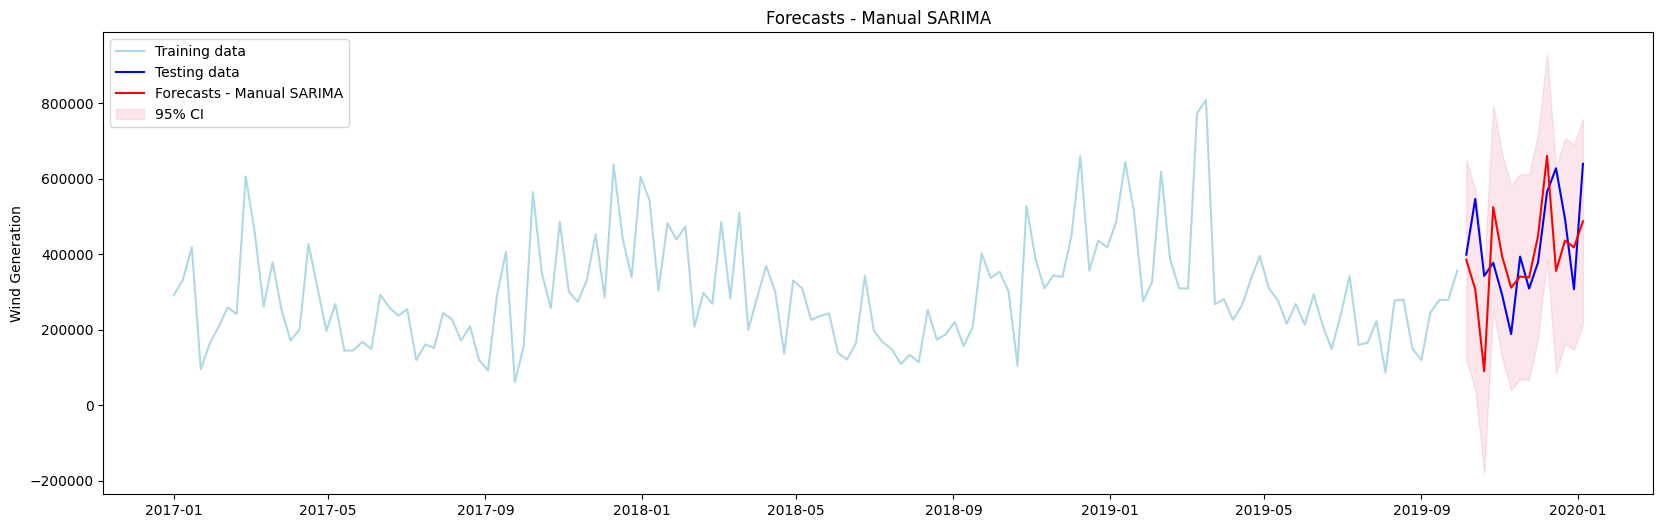

In [ ]:
model_SARIMA = result_SARIMA_1.get_prediction(start=test_weekly.index[0], end=test_weekly.index[-1])
df_sarima = model_SARIMA.summary_frame()
plt.figure(figsize=(20, 6))
plt.plot(train_weekly, color='lightblue',label='Training data')
plt.plot(test_weekly, color='blue', label='Testing data')
plt.plot(df_sarima['mean'], color='red', label='Forecasts - Manual SARIMA')
plt.fill_between(df_sarima.index, df_sarima['mean_ci_lower'], df_sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.ylabel('Wind Generation')
plt.title('Forecasts - Manual SARIMA')

plt.legend();
plt.show()

In [ ]:
# Metrics
aic_sarima = result_SARIMA_1.aic
rmse = np.sqrt(mean_squared_error(test_weekly, df_sarima['mean']))
mae = mean_absolute_error(test_weekly, df_sarima['mean'])
mape = mean_absolute_percentage_error(test_weekly, df_sarima['mean']) * 100

sarima_row = pd.DataFrame([{
    'Model': 'Manual SARIMA',
    'AIC': aic_sarima,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape
}])

metrics = pd.concat([ets_metrics, sarima_row], ignore_index=True)
metrics

Model          AIC           RMSE            MAE   MAPE (%)
0         ETS Weekly   3928.529231  116867.610549  104052.571275   0.286875
1  Damped ETS Weekly   3923.621884  110534.635879   90815.901091   0.236406
2       Manual SARIMA  2380.142631  146147.822327  122741.377218  30.992949

### 4.3.2 - AutoSARIMA

In [ ]:
!pip install numpy==1.23.5

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima

In [ ]:
stepwise_model = auto_arima(train_weekly, start_p=0, start_q=0, d=0,
                          max_p=2, max_q=2, m=52,
                           start_P=0, start_Q=0,max_P = 2, max_Q = 2, D = 1, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                           n_jobs=4)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2457.831, Time=0.39 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2449.241, Time=17.81 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=2449.548, Time=22.19 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=2470.925, Time=0.85 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=2459.216, Time=0.95 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=2451.216, Time=22.23 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=6.90 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=2446.018, Time=6.47 sec
 ARIMA(1,0,0)(0,1,2)[52] intercept   : AIC=2447.243, Time=17.72 sec
 ARIMA(1,0,0)(1,1,2)[52] intercept   : AIC=inf, Time=33.46 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=2450.744, Time=3.74 sec
 ARIMA(2,0,0)(0,1,1)[52] intercept   : AIC=2444.349, Time=4.69 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=2458.546, Time=0.69 sec
 ARIMA(2,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=12.52 sec
 ARIMA(2,0,0)(0,1,2)[52] int

This results in an ARIMA(2,0,0)(1,1,2)[52] model as optimal (~10 min)

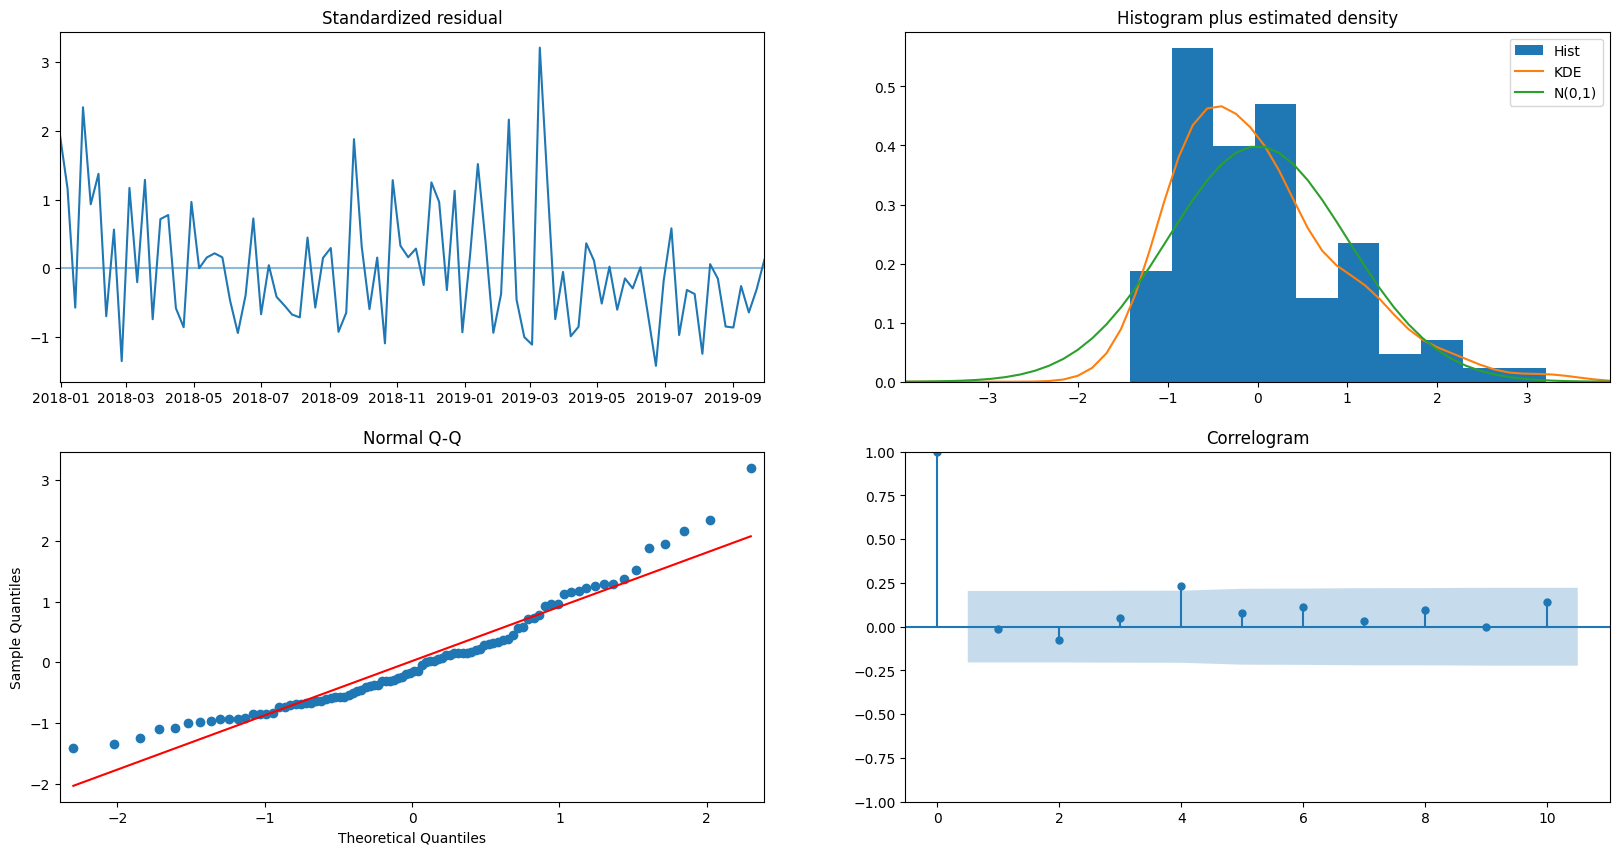

In [ ]:
stepwise_model.plot_diagnostics(figsize=(20,10));

In [ ]:
print('Ljung-Box test: ')
ljung_test = acorr_ljungbox(stepwise_model.resid(), period=52)
ljung_test.head()

Ljung-Box test: 


lb_stat     lb_pvalue
1  10.072116  1.505301e-03
2  17.398523  1.667089e-04
3  35.256008  1.075584e-07
4  58.498602  5.996603e-12
5  65.734611  7.890164e-13

In [ ]:
print('Durbin watson: ',durbin_watson(stepwise_model.resid()))

Durbin watson:  1.2715954212445284


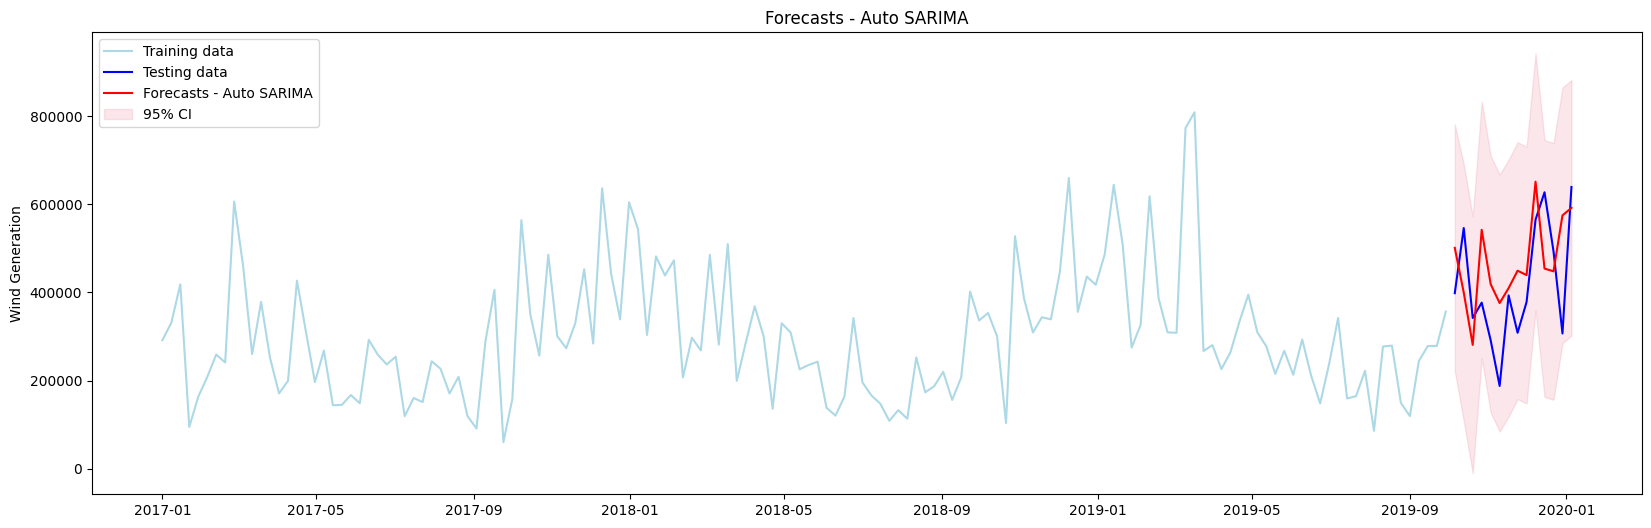

In [ ]:
# Predictions
forecast, conf_int = stepwise_model.predict(n_periods=len(test_weekly), return_conf_int=True, alpha=0.05)

# DataFrame construction
df_auto_sarima = pd.DataFrame({
    'mean': forecast,
    'mean_ci_lower': conf_int[:, 0],
    'mean_ci_upper': conf_int[:, 1]
}, index=test_weekly.index)

# Plot
plt.figure(figsize=(20, 6))
plt.plot(train_weekly, color='lightblue', label='Training data')
plt.plot(test_weekly, color='blue', label='Testing data')
plt.plot(df_auto_sarima['mean'], color='red', label='Forecasts - Auto SARIMA')
plt.fill_between(df_auto_sarima.index, df_auto_sarima['mean_ci_lower'],df_auto_sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.ylabel('Wind Generation')
plt.title('Forecasts - Auto SARIMA')

plt.legend()
plt.show()



In [ ]:
# Metrics
aic_auto_sarima = stepwise_model.aic()
rmse = np.sqrt(mean_squared_error(test_weekly, df_auto_sarima['mean']))
mae = mean_absolute_error(test_weekly, df_auto_sarima['mean'])
mape = mean_absolute_percentage_error(test_weekly, df_auto_sarima['mean']) * 100

auto_sarima_row = pd.DataFrame([{
    'Model': 'Auto SARIMA',
    'AIC': aic_auto_sarima,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape
}])

metrics = pd.concat([metrics, auto_sarima_row], ignore_index=True)
metrics

Model          AIC           RMSE            MAE   MAPE (%)
0         ETS Weekly   3928.529231  116867.610549  104052.571275   0.286875
1  Damped ETS Weekly   3923.621884  110534.635879   90815.901091   0.236406
2       Manual SARIMA  2380.142631  146147.822327  122741.377218  30.992949
3         Auto SARIMA  2443.498401  134128.197540  116380.128169  33.615468



While both SARIMA models achieve significantly better AIC values (indicating better fit on the training data), the ETS models—especially the damped version—perform better on the test set in terms of forecast accuracy (lower RMSE, MAE, and MAPE).

Therefore, ETS may be preferable for short-term forecasting in this case, despite the stronger in-sample fit of SARIMA.


###4.3.3 - SARIMAX Temperature

I have two additional features in the dataset that could be used to improve the forecasting: `temperature` and `wind_capacity`.

Earlier, in section 2.1.5, the correlation matrix showed a negative correlation between **`temperature`** and **`wind_generation`**.

Therefore, I will first try including temperature as an exogenous variable in a SARIMAX model to see if it improves forecast accuracy.

In [ ]:
# Split of training & testing data for exogenous variable

temperature_weekly = df_weekly['temperature']
temperature_weekly_train = temperature_weekly[:-14]
temperature_weekly_test = temperature_weekly[-14:]
display(temperature_weekly_train.tail())
display(temperature_weekly_test.head())

utc_timestamp
2019-09-01 00:00:00+00:00    22.728286
2019-09-08 00:00:00+00:00    14.978143
2019-09-15 00:00:00+00:00    15.421143
2019-09-22 00:00:00+00:00    13.132000
2019-09-29 00:00:00+00:00    14.607857
Freq: W-SUN, Name: temperature, dtype: float64

utc_timestamp
2019-10-06 00:00:00+00:00    10.324429
2019-10-13 00:00:00+00:00    11.860000
2019-10-20 00:00:00+00:00    13.160286
2019-10-27 00:00:00+00:00    12.004571
2019-11-03 00:00:00+00:00     6.273714
Freq: W-SUN, Name: temperature, dtype: float64

For simplicity, I opted to reuse the Manual SARIMA parameters, as the performance differences with Auto SARIMA were minimal and did not justify the added complexity.

In [ ]:
model_sarimax_temp = SARIMAX(
    train_weekly,
    exog=temperature_weekly_train.values.reshape(-1, 1),
    order=(2, 0, 2),
    seasonal_order=(0, 1, 0, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result_sarimax_temp = model_sarimax_temp.fit()

print(result_sarimax_temp.summary())


                                      SARIMAX Results                                      
Dep. Variable:                     wind_generation   No. Observations:                  144
Model:             SARIMAX(2, 0, 2)x(0, 1, [], 52)   Log Likelihood               -1183.737
Date:                             Tue, 17 Jun 2025   AIC                           2379.474
Time:                                     19:08:49   BIC                           2394.406
Sample:                                 01-01-2017   HQIC                          2385.493
                                      - 09-29-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4933.3810   2704.219      1.824      0.068    -366.792    1.02e+04
ar.L1          0.4062      

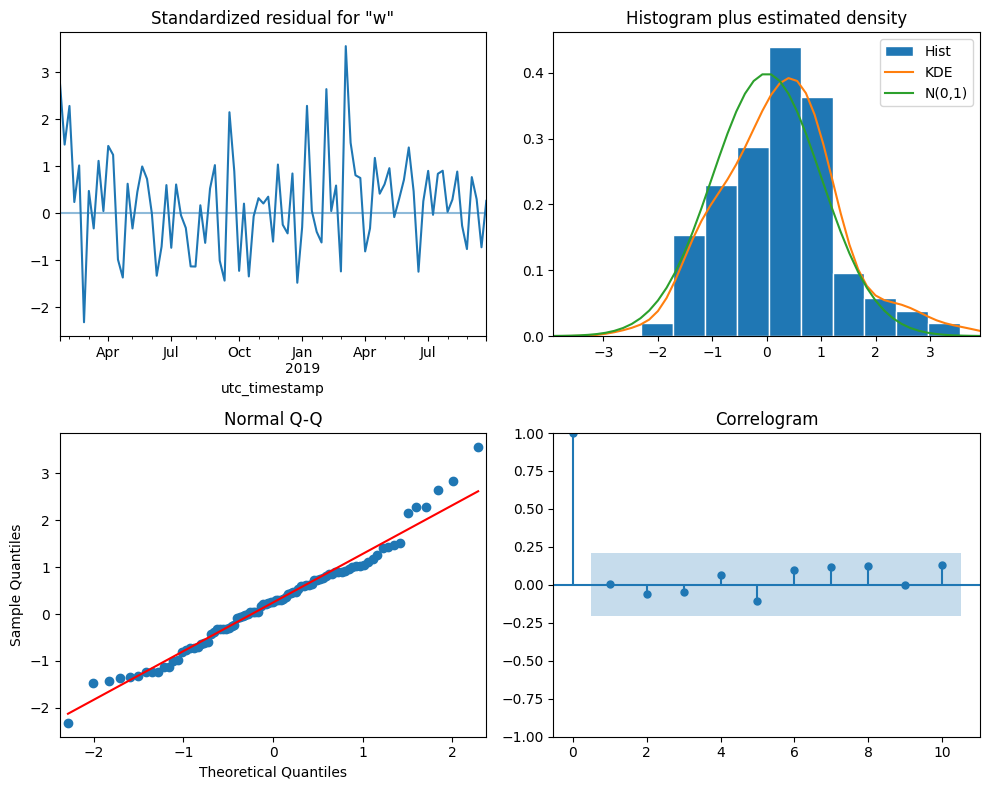

In [ ]:
result_sarimax_temp.plot_diagnostics(figsize=(10, 8));
plt.tight_layout()
plt.show()

In [ ]:
print('Ljung-Box test: ')
ljung_test = acorr_ljungbox(result_sarimax_temp.resid, period=52)
ljung_test.head()

Ljung-Box test: 


lb_stat     lb_pvalue
1   38.809371  4.672792e-10
2   69.650334  7.509691e-16
3  102.255057  5.088217e-22
4  134.493764  4.257287e-28
5  152.578516  3.771950e-31

In [ ]:
print('Durbin watson: ',durbin_watson(result_sarimax_temp.resid))

Durbin watson:  0.6756905089139019


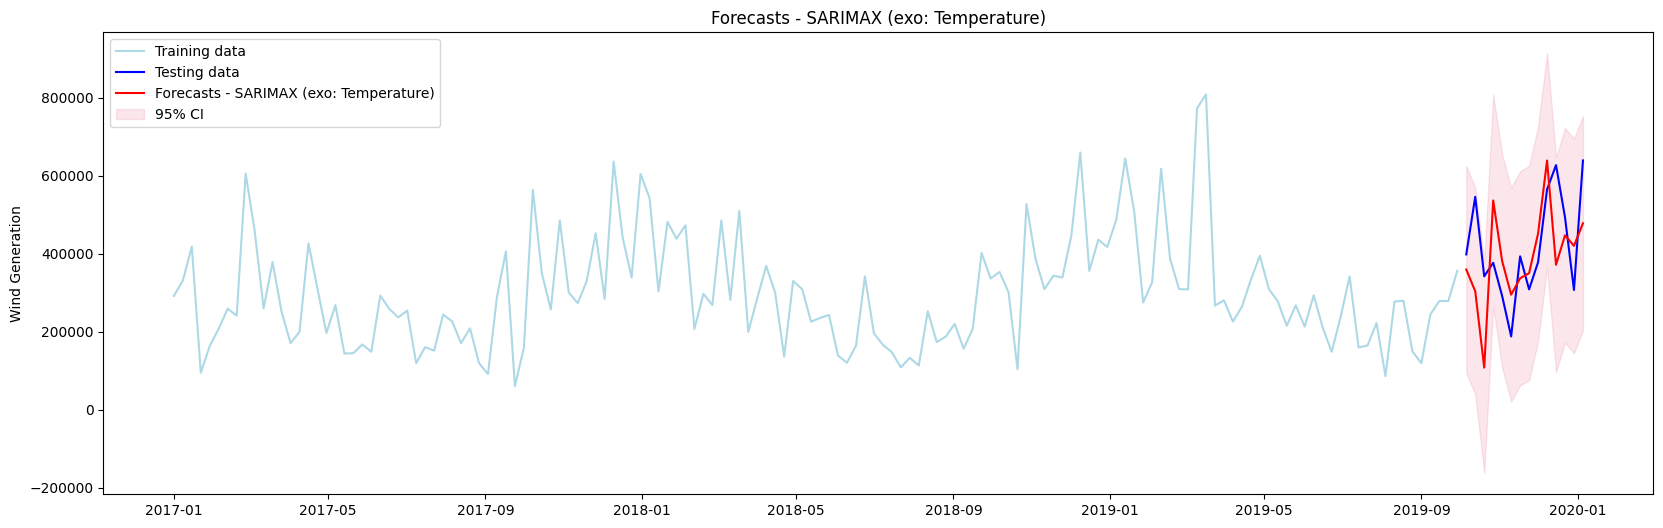

In [ ]:
# Forecasting with Manual SARIMAX model

model_SARIMAX_temp = result_sarimax_temp.get_prediction(start=test_weekly.index[0], end=test_weekly.index[-1], exog=temperature_weekly_test.values.reshape(-1, 1))
df_sarima = model_SARIMAX_temp.summary_frame()

plt.figure(figsize=(20, 6))
plt.plot(train_weekly, color='lightblue',label='Training data')
plt.plot(test_weekly, color='blue', label='Testing data')
plt.plot(df_sarima['mean'], color='red', label='Forecasts - SARIMAX (exo: Temperature)')
plt.fill_between(df_sarima.index, df_sarima['mean_ci_lower'], df_sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.ylabel('Wind Generation')
plt.title('Forecasts - SARIMAX (exo: Temperature)')

plt.legend();
plt.show()

In [ ]:
# Metrics
rmse = np.sqrt(mean_squared_error(test_weekly, df_sarima['mean']))
mae = mean_absolute_error(test_weekly, df_sarima['mean'])
mape = mean_absolute_percentage_error(test_weekly, df_sarima['mean']) * 100
aic = result_sarimax_temp.aic

sarimax_temp_metrics = pd.DataFrame([{
    'Model': 'Temperature SARIMAX',
    'AIC': aic,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape
}])

metrics = pd.concat([metrics, sarimax_temp_metrics], ignore_index=True)
metrics

Model          AIC           RMSE            MAE   MAPE (%)
0          ETS Weekly   3928.529231  116867.610549  104052.571275   0.286875
1   Damped ETS Weekly   3923.621884  110534.635879   90815.901091   0.236406
2        Manual SARIMA  2380.142631  146147.822327  122741.377218  30.992949
3          Auto SARIMA  2443.498401  134128.197540  116380.128169  33.615468
4  Temperature SARIMAX  2379.474375  141930.296424  120938.022799  30.360897

The SARIMAX model with temperature as the only exogenous variable achieves a slightly better AIC.

Considering that the Temperature SARIMAX model uses the same parameters as the Manual SARIMA, its slightly better RMSE, MAE, and MAPE suggest that including temperature does improve forecast accuracy to some extent. However, the improvement is limited.


###4.3.4 - SARIMAX Temp + WindCapacity

In [ ]:
# Prepare exog var
exog_train = df_weekly[['temperature', 'wind_capacity']][:-14]
exog_test = df_weekly[['temperature', 'wind_capacity']][-14:]

# SARIMAX modelwith both exog var
model_sarimax_exog = SARIMAX(
    train_weekly,
    exog=exog_train,
    order=(2, 0, 2),
    seasonal_order=(0, 1, 0, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result_sarimax_exog = model_sarimax_exog.fit()
print(result_sarimax_exog.summary())

                                      SARIMAX Results                                      
Dep. Variable:                     wind_generation   No. Observations:                  144
Model:             SARIMAX(2, 0, 2)x(0, 1, [], 52)   Log Likelihood               -1181.786
Date:                             Tue, 17 Jun 2025   AIC                           2377.572
Time:                                     19:08:58   BIC                           2394.993
Sample:                                 01-01-2017   HQIC                          2384.594
                                      - 09-29-2019                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
temperature    3826.3868   2733.895      1.400      0.162   -1531.949    9184.723
wind_capacity     

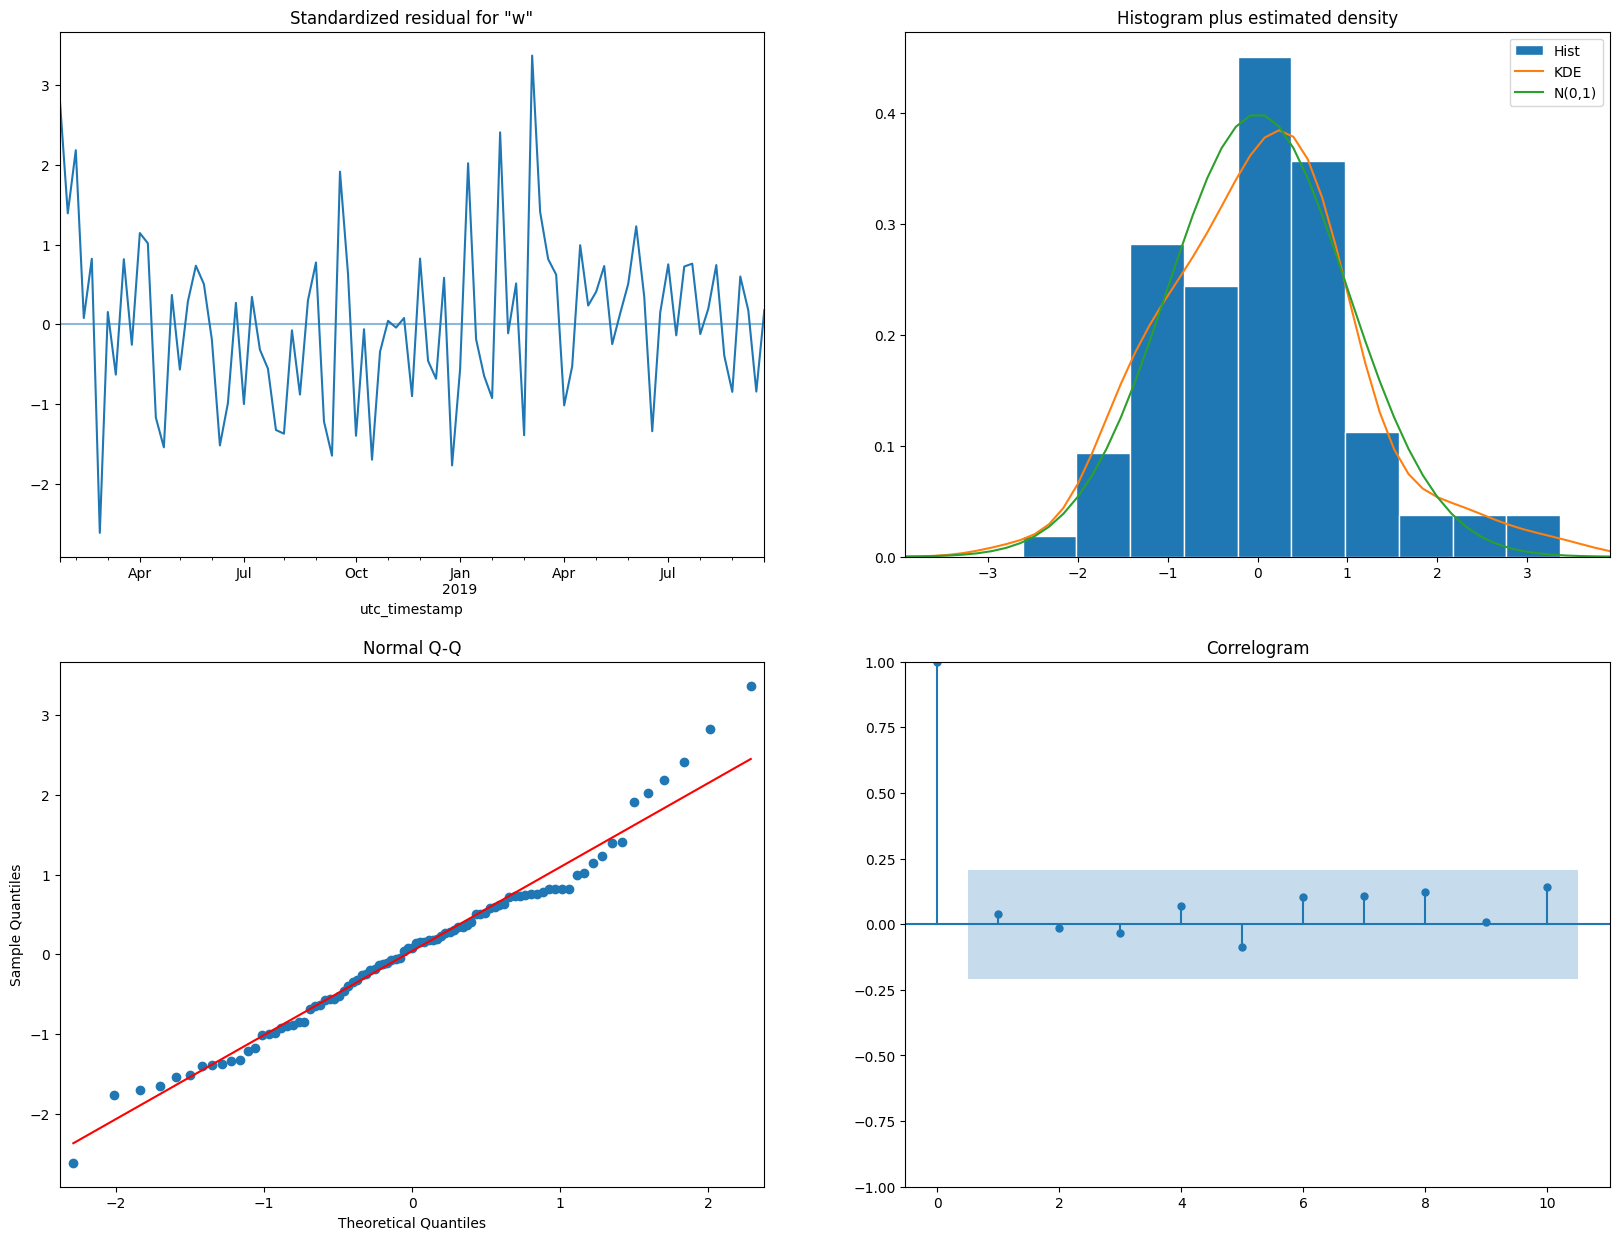

In [ ]:
result_sarimax_exog.plot_diagnostics(figsize=(20, 15));
plt.show()

In [ ]:
print('Ljung-Box test: ')
ljung_test = acorr_ljungbox(result_sarimax_exog.resid, period=52)
ljung_test.head()

Ljung-Box test: 


lb_stat     lb_pvalue
1  11.994939  5.334523e-04
2  19.210870  6.736164e-05
3  29.480142  1.775087e-06
4  38.934855  7.185666e-08
5  40.481731  1.193937e-07

In [ ]:
print('Durbin watson: ',durbin_watson(result_sarimax_temp.resid))

Durbin watson:  0.6756905089139019


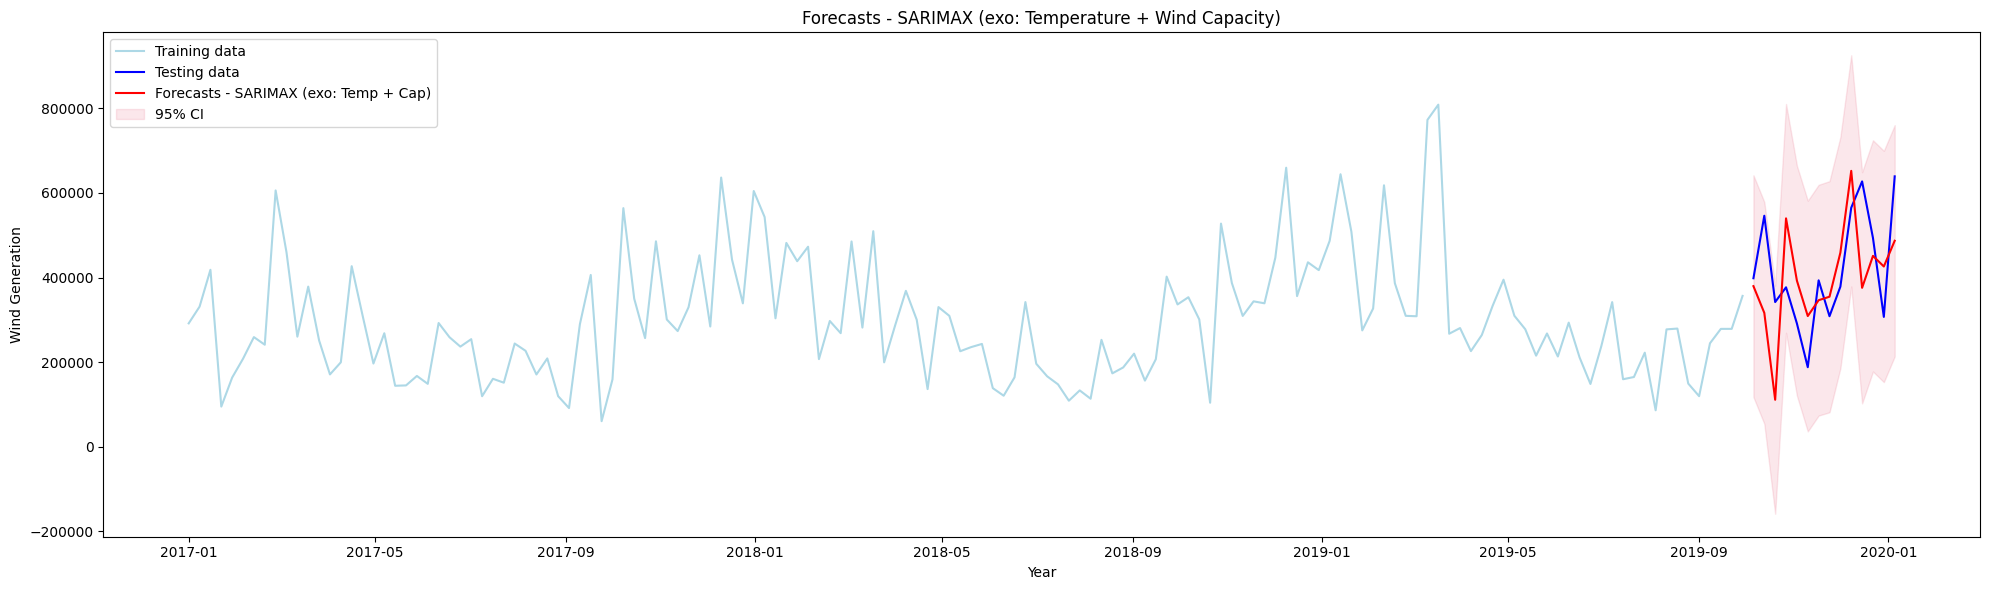

In [ ]:
# Predictions
forecast_exog = result_sarimax_exog.get_prediction(
    start=test_weekly.index[0],
    end=test_weekly.index[-1],
    exog=exog_test
)
df_forecast_exog = forecast_exog.summary_frame()

# Plot
plt.figure(figsize=(20, 6))
plt.plot(train_weekly, color='lightblue',label='Training data')
plt.plot(test_weekly, color='blue', label='Testing data')
plt.plot(df_forecast_exog['mean'], color='red', label='Forecasts - SARIMAX (exo: Temp + Cap)')
plt.fill_between(df_forecast_exog.index, df_forecast_exog['mean_ci_lower'], df_forecast_exog['mean_ci_upper'], alpha=0.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Wind Generation')
plt.title('Forecasts - SARIMAX (exo: Temperature + Wind Capacity)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Metrics
rmse = np.sqrt(mean_squared_error(test_weekly, df_forecast_exog['mean']))
mae = mean_absolute_error(test_weekly, df_forecast_exog['mean'])
mape = mean_absolute_percentage_error(test_weekly, df_forecast_exog['mean']) * 100
aic = result_sarimax_exog.aic

sarimax_exog_metrics = pd.DataFrame([{
    'Model': 'Temp + WindCap SARIMAX',
    'AIC': aic,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape
}])
metrics = pd.concat([metrics, sarimax_exog_metrics], ignore_index=True)
metrics

Model          AIC           RMSE            MAE  \
0             ETS Weekly   3928.529231  116867.610549  104052.571275   
1      Damped ETS Weekly   3923.621884  110534.635879   90815.901091   
2           Manual SARIMA  2380.142631  146147.822327  122741.377218   
3             Auto SARIMA  2443.498401  134128.197540  116380.128169   
4     Temperature SARIMAX  2379.474375  141930.296424  120938.022799   
5  Temp + WindCap SARIMAX  2377.572392  141128.160661  120766.755638   

    MAPE (%)  
0   0.286875  
1   0.236406  
2  30.992949  
3  33.615468  
4  30.360897  
5  30.817054

Adding both temperature and wind capacity as exogenous variables slightly improves model fit, achieving the lowest AIC and marginally better forecast accuracy.


###4.3.4 - VAR (Vector Autoregressive Model)

One limitation of the models that we have considered so far is that they impose a unidirectional relationship, that is the forecast variable is influenced by the predictor variables, but not vice versa. We have seen how to incorporate, for example with SARIMAX models, the impact of exogenous variables on a time series. However, such relationship is unidirectional, thus we assume that the exogenous variable has an impact on the target only. However, it is possible that two time series have a bi-directional relationship, meaning that time series t1 is a predictor of time series t2, and time series t2 is also a predictor for time series t1. Indeed, there are many cases where the reverse should also be allowed for, as all variables affect each other and thus a bi-directional relationship might be more suitable. A **vector autoregressive (VAR)** model is a generalisation of the univariate autoregressive model for forecasting a vector of multiple time series. It comprises one equation per variable in the system.


If the series are stationary, we forecast them by fitting a VAR to the data directly (known as a “VAR in levels”). If the series are non-stationary, we take differences of the data in order to make them stationary, then fit a VAR model (known as a “VAR in differences”).

In [ ]:
train_VAR = df_weekly[['wind_generation', 'temperature' ]][:-14]
test_VAR = df_weekly[['wind_generation', 'temperature']][-14:]

In [ ]:
train_VAR_diff = train_VAR.diff(52).dropna()

In [ ]:
print('Temperature stationary test\n')
adfuller_test(train_VAR_diff.temperature)
kpss_test_c(train_VAR_diff.temperature)
kpss_test_ct(train_VAR_diff.temperature)
print('---\n')
print('Wind generation stationary test\n')
adfuller_test(train_VAR_diff.wind_generation)
kpss_test_c(train_VAR_diff.wind_generation)
kpss_test_ct(train_VAR_diff.wind_generation)
print('---\n')

Temperature stationary test

ADF Statistic: -5.323328144539453
p-value:  4.898172771512997e-06
--------------------------------------
We can reject the null hypothesis (H0) --> data is stationary
KPSS Statistic: 0.1417098599401352
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is level - stationary
KPSS Statistic: 0.04541059861767472
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
---

Wind generation stationary test

ADF Statistic: -8.685300617795662
p-value:  4.179098747666661e-14
--------------------------------------
We can reject the null hypothesis (H0) --> data is stationary
KPSS Statistic: 0.1250846203236924
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is level - stationary
KPSS Statistic: 0.1307484416830813
p-value:  0.07824362651281239
We cannot reject the null hypothesis (H0) --> data is trend stationary
---



**Granger Causality**

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
# From Python documentation:
# Four tests for granger non causality of 2 time series. All four tests give similar results
# The null hypothesis for 'grangercausalitytests' is that the time series in
# the second column, x2, does NOT Granger cause the time series in the first
# column, x1.
# Grange causality means that past values of x2 have a statistically significant effect on the current value of x1,
# besides taking past values of x1 into account as regressors.

print('temperature Granger-causes wind_generation?')
print('------------------')
granger_1 = grangercausalitytests(train_VAR_diff[['wind_generation', 'temperature']], 15) # all lags up to 8 will be tested

print('\nwind_generation Granger-causes temperature?')
print('------------------')
granger_2 = grangercausalitytests(train_VAR_diff[['temperature', 'wind_generation']], 15)

# x Granger causes y if p-value of a lag <= 0.05  (x aiuta a prevedere y)

temperature Granger-causes wind_generation?
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2310  , p=0.2702  , df_denom=88, df_num=1
ssr based chi2 test:   chi2=1.2730  , p=0.2592  , df=1
likelihood ratio test: chi2=1.2642  , p=0.2609  , df=1
parameter F test:         F=1.2310  , p=0.2702  , df_denom=88, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2242  , p=0.2991  , df_denom=85, df_num=2
ssr based chi2 test:   chi2=2.5925  , p=0.2736  , df=2
likelihood ratio test: chi2=2.5558  , p=0.2786  , df=2
parameter F test:         F=1.2242  , p=0.2991  , df_denom=85, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5236  , p=0.2146  , df_denom=82, df_num=3
ssr based chi2 test:   chi2=4.9609  , p=0.1747  , df=3
likelihood ratio test: chi2=4.8275  , p=0.1849  , df=3
parameter F test:         F=1.5236  , p=0.2146  , df_denom=82, df_num=3

Granger Causality
number of lags (no

Although temperature does not Granger-cause wind_generation, we observed that wind_generation does Granger-cause temperature starting from lag 8.
Given this statistical relationship, we will proceed to test a multivariate model (VAR) to evaluate whether the joint dynamics can improve forecasting performance.

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

# Automatic lag selection for VAR model
model = VAR(train_VAR_diff)
x = model.select_order(maxlags=10)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

lag = 2 is the best model

In [ ]:
# Fit the optimal VAR model
best_model_VAR = VARMAX(train_VAR_diff, order=(2,0)).fit(disp=False)
print(best_model_VAR.summary())

                                   Statespace Model Results                                   
Dep. Variable:     ['wind_generation', 'temperature']   No. Observations:                   92
Model:                                         VAR(2)   Log Likelihood               -1470.970
                                          + intercept   AIC                           2967.940
Date:                                Tue, 17 Jun 2025   BIC                           3000.723
Time:                                        19:09:03   HQIC                          2981.171
Sample:                                    12-31-2017                                         
                                         - 09-29-2019                                         
Covariance Type:                                  opg                                         
Ljung-Box (L1) (Q):             0.05, 0.00   Jarque-Bera (JB):           3.23, 1.17
Prob(Q):                        0.83, 1.00   Prob(JB):       

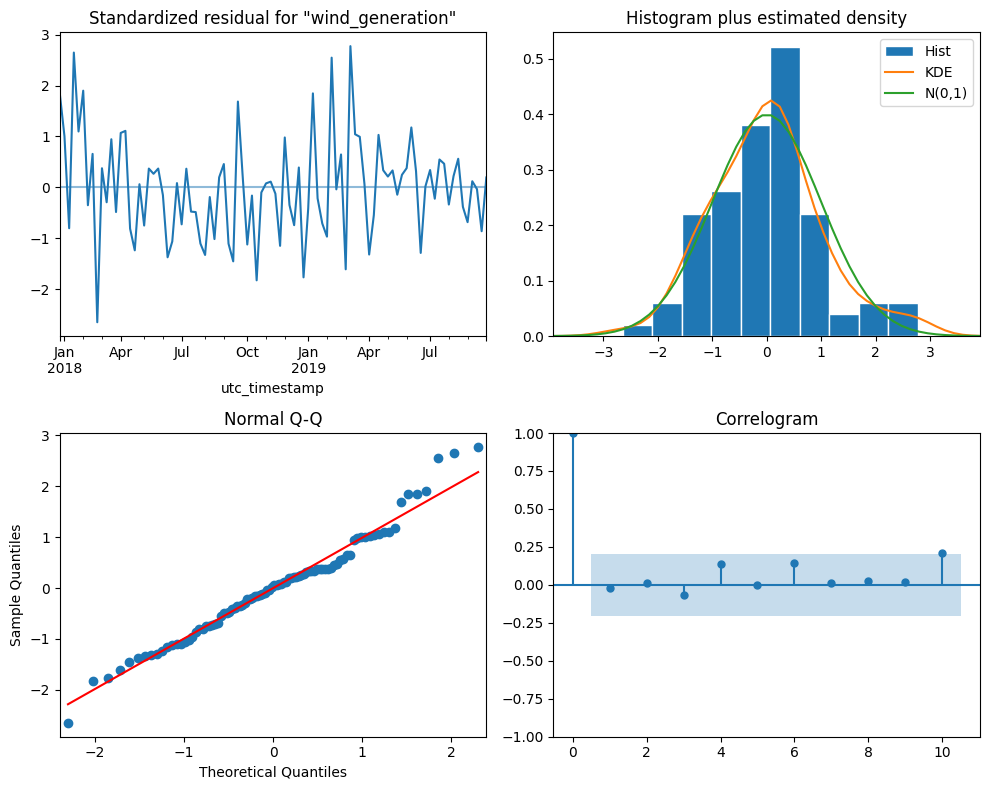

In [ ]:
# Plot diagnostic for wind_generation
best_model_VAR.plot_diagnostics(figsize=(10,8), variable=0);
plt.tight_layout()

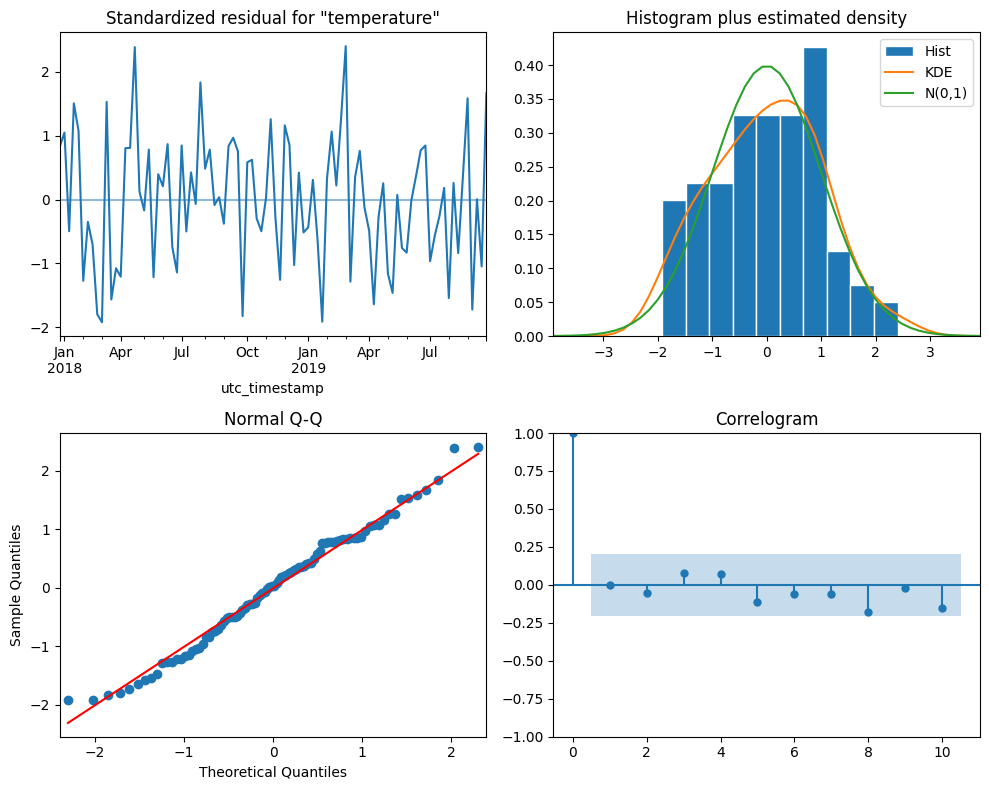

In [ ]:
# Plot diagnostic for temperature
best_model_VAR.plot_diagnostics(figsize=(10,8), variable=1);
plt.tight_layout()

In [ ]:
# Forecast
predictions = best_model_VAR.get_prediction(start=test_VAR.index[0], end=test_VAR.index[-1])
oos_pred_temperature = predictions.predicted_mean['temperature']
oos_pred_wind_generation_actual = predictions.predicted_mean['wind_generation']

In [ ]:
from datetime import timedelta

def invert_transformation(df_train):
     forecasting =  pd.DataFrame(columns=['wind_generation']) #data_test
     df_fc = predictions.predicted_mean.wind_generation
     ls = dict()
     for idx in df_fc.index:
          value = df_train[idx - timedelta(weeks=52)] + (df_fc[idx])
          ls[idx] = value
     forecasting = pd.DataFrame(ls.items(),columns=['date_time','wind_generation'])
     forecasting.index = forecasting.date_time
     forecasting.drop('date_time', inplace=True, axis=1)
     return forecasting
df_results = invert_transformation(train_VAR.wind_generation)

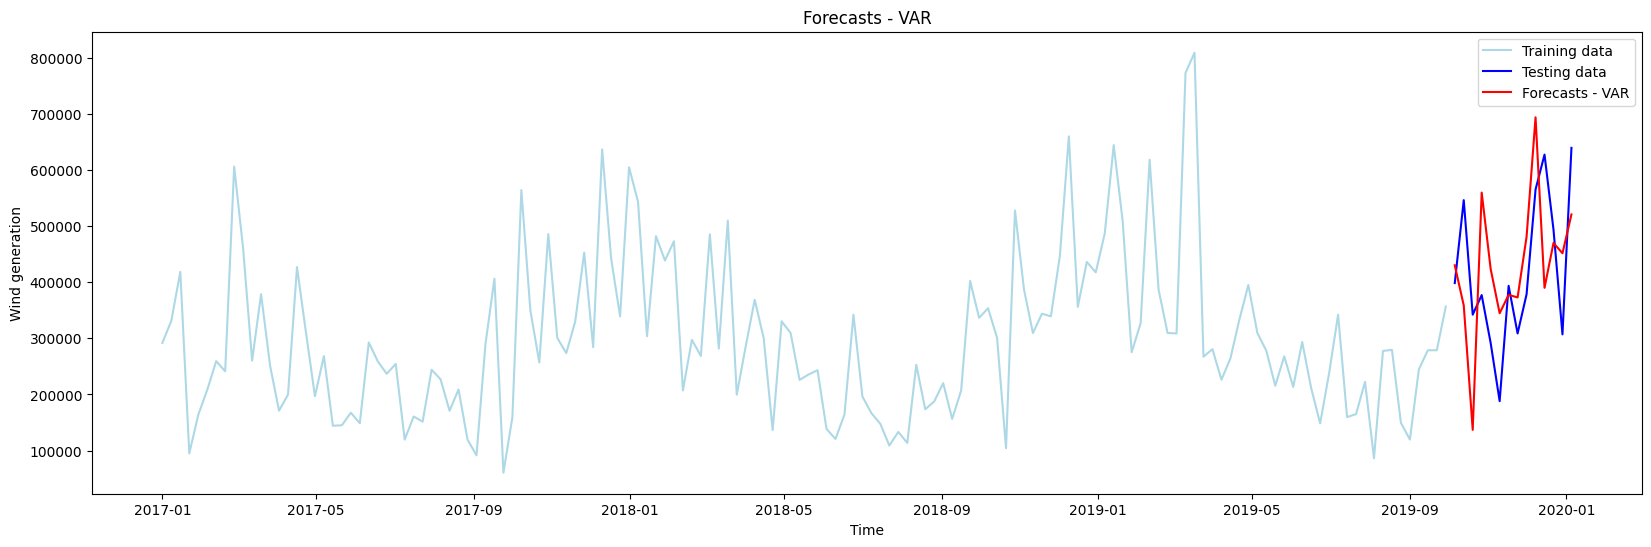

In [ ]:
# Visualize the results
plt.figure(figsize=(20,6))
plt.plot(train_VAR.wind_generation,'lightblue', label='Training data')
plt.plot(test_VAR.wind_generation,'blue', label='Testing data')
plt.plot(df_results,'-r', label='Forecasts - VAR')
plt.xlabel('Time')
plt.ylabel('Wind generation')
plt.title('Forecasts - VAR')

plt.legend()
plt.show()

In [ ]:
# Metrics

df_results = df_results.loc[test_VAR.index]
aic_varmax = best_model_VAR.aic

rmse = np.sqrt(mean_squared_error(test_VAR['wind_generation'], df_results['wind_generation']))
mae = mean_absolute_error(test_VAR['wind_generation'], df_results['wind_generation'])
mape = mean_absolute_percentage_error(test_VAR['wind_generation'], df_results['wind_generation']) * 100

varmax_metrics = pd.DataFrame([{
    'Model': 'VAR',
    'AIC' : aic_varmax,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape
}])

metrics = pd.concat([metrics, varmax_metrics], ignore_index=True)
metrics

Model          AIC           RMSE            MAE  \
0             ETS Weekly   3928.529231  116867.610549  104052.571275   
1      Damped ETS Weekly   3923.621884  110534.635879   90815.901091   
2           Manual SARIMA  2380.142631  146147.822327  122741.377218   
3             Auto SARIMA  2443.498401  134128.197540  116380.128169   
4     Temperature SARIMAX  2379.474375  141930.296424  120938.022799   
5  Temp + WindCap SARIMAX  2377.572392  141128.160661  120766.755638   
6                     VAR  2967.939641  140646.828567  123673.075702   

    MAPE (%)  
0   0.286875  
1   0.236406  
2  30.992949  
3  33.615468  
4  30.360897  
5  30.817054  
6  33.019866

The VAR model performs similarly to the SARIMA and SARIMAX models in terms of RMSE, MAE, and MAPE. Although its AIC is slightly higher, the overall forecast accuracy is comparable. This suggests that VAR is a valid alternative for modeling when multiple related time series are available, but it does not clearly outperform SARIMA-based models in this case.

#**Conclusions**

Among all the models evaluated, the Damped ETS achieves the best forecast accuracy, with the lowest RMSE, MAE, and MAPE values. However, the lowest AIC is obtained by the SARIMAX model with both temperature and wind capacity as exogenous variables, indicating the best in-sample fit. This suggests that incorporating external regressors can improve model structure, even if the improvement in forecast accuracy is only marginal.
The VAR model also performs comparably to SARIMAX, confirming that multivariate models can be effective, though not necessarily superior to well-tuned univariate approaches.

Overall, the choice between models depends on the trade-off between simplicity, interpretability, and the inclusion of relevant external information.



In this case, the **manually tuned SARIMA** model offers the best trade-off between complexity and forecasting performance.
Although the inclusion of exogenous variables (SARIMAX) and multivariate structures (VAR) can theoretically enhance model capacity, they did not lead to substantial improvements in this dataset.